# Indian Liver Patient (ILPD) Dataset
Data Spaces (01RLPOV), A.A. 2021/22  <br /> 
Politecnico di Torino - Corso di Laurea Magistrale in Ingegneria Informatica <br /> 
Elisa Cenedese - s255202 <br /> 


## Table of Contents

* [1. Introduction](#introduction)
    * [1.1 Dataset description](#dataset_descr)
    * [1.2 Check for missing values](#check_missing_values)
    * [1.3 Check for outliers](#check_outliers)
    * [1.4 Split dataset](#split_dataset)
* [2. Exploratory data analysis](#exploratory_data_analysis)
    * [2.1 Statistical quantitative description of features](#stat_features_descr)
    * [2.2 Box plots](#box_plots)
    * [2.3 Correlation analysis](#corr_analysis)
* [3. Preprocessing steps](#preprocessing_steps)
    * [3.1 Feature scaling](#scaling)
    * [3.2 Rebalancing](#rebalancing)
    * [3.3 Dimensionality reduction methods](#dim_reduction_methods)
       * [3.3.1 Principal component analysis](#pca)
       * [3.3.2 Empirical feature selection](#empirical_feature_selection)
* [4. Classification](#classification)
    * [4.1 Metrics](#metrics)
    * [4.2 Cross validation](#cv)
    * [4.3 Support vector machines](#svm)
    * [4.4 K nearest neighbors](#knn)
    * [4.5 Logistic regression](#l_regr)
    * [4.6 Decision Tree](#decision_tree)
    * [4.7 Random forest](#random_forest)
  

In [1]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Install
!pip install chart_studio
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 1.5 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=6acfae2e85fdca9f879554e267a59b2273911df6b0873b7643f93dde1f9e6a22
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79.9 MB 121 kB/s 


In [3]:
%matplotlib inline

#Imports
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import itertools
import math
import pickle
from numpy import mean
from numpy import std
#plot libaries
import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import yaml
import pprint

from imblearn.over_sampling import SMOTENC
from matplotlib.colors import ListedColormap
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, f1_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn import tree, svm, linear_model, ensemble, neighbors 
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.base import clone
#from plotly.offline import init_notebook_mode
#init_notebook_mode(connected=True)
# online plotly
import chart_studio
chart_studio.tools.set_credentials_file(username='elisa_c', api_key='ixjDGQPn6k6yG1D96Wnr')
#chart_studio.tools.set_config_file(world_readable=False, sharing='secret')
import chart_studio.plotly as py
from scipy.cluster import hierarchy as hc

In [4]:
#Paths
DATA_FILE_NAME = "indian_liver_patient_dataset.csv"

ROOT_DIRPATH = os.path.join(
    '/content',
    'drive',
    'MyDrive',
    'DataSpaces',
    'DataSpaces_project',
)

DATA_DIRPATH = os.path.join(
    ROOT_DIRPATH,
    'data',
)

MODELS_DIRPATH = os.path.join(
    ROOT_DIRPATH,
    'models',
)

data_file_path = os.path.join(DATA_DIRPATH, DATA_FILE_NAME)

if not os.path.exists(MODELS_DIRPATH):
    os.makedirs(MODELS_DIRPATH)

In [5]:
def read_dataset(dirpath: str, file_type: str, sheet_name_=None):
  if file_type == "xlsx":
    dataset_df = pd.read_excel(dirpath, sheet_name= sheet_name_)
  elif file_type == "csv":
    with open(dirpath) as in_fp:
      dataset_df = pd.read_csv(in_fp, sep=',', header=0)
  else:
    raise Exception("Unrecognised dataset format")
  return dataset_df

In [6]:
def show_dict(dict_: dict):
    pprint.pprint(dict_, width=1)

In [7]:
def print_formatted_list(str_, list):
  print(str_ + ":")
  for value in list:
    print("  - " + str(value))
  print()

In [8]:
def prepare_bar_plot(df, title, template_):
  colors = plotly.colors.DEFAULT_PLOTLY_COLORS
  data_series = df.value_counts() # return series
  data = [go.Bar(x=data_series.index, y=data_series.values, marker = dict(color = colors[:len(data_series.index)]))]
  layout = go.Layout(
      #paper_bgcolor='rgba(0,0,0,0)',
      #plot_bgcolor='rgba(0,0,0,0)',
      title=title,
      template = template_,
      autosize=False,
      width=400,
      height=400,
      yaxis=dict(
          title='#Patients',
      ),
  )
  fig = go.Figure(data=data, layout=layout)
  return fig, data_series

In [9]:
def prepare_bar_plots(df1, df2, title, template_):

  colors = plotly.colors.DEFAULT_PLOTLY_COLORS
  data_series1 = df1.value_counts() # return series 
  data_series2 = df2.value_counts() # return series 

  fig = make_subplots(rows=1, cols=2,  subplot_titles=("Train", "Test"))

  fig.add_trace(
      go.Bar(x=data_series1.index, y=data_series1.values, marker = dict(color = colors[:len(data_series1.index)])),
      row=1, col=1
  )

  fig.add_trace(
      go.Bar(x=data_series2.index, y=data_series2.values, marker = dict(color = colors[:len(data_series2.index)])),
      row=1, col=2
  )

  fig.update_layout(title=title,
      template = template_,
      autosize=True,
      showlegend=False,
      width=400,
      height=400,
      yaxis=dict(
          title='#Patients',
      ))
  
  return fig, data_series1, data_series2

In [10]:
def prepare_histogram_plot(X, features_names, class_names, config_dict, template_, per_feature=True):
  start_pos = 0
  data = []
  num_steps = len(features_names)

  for count_class, target in enumerate(class_names):
    trace_list = []
    for count, feature in enumerate(features_names):
      if count != start_pos:
        trace_list.append(go.Histogram(x=X[feature].loc[X[config_dict['TARGET_COLUMN_NAME']] == target], name = target, visible = False))
      else: 
        if per_feature and (count_class == 0 or count_class == 1):
            visibility_ =  True
        else:
            visibility_ =  'legendonly'
        trace_list.append(go.Histogram(x=X[feature].loc[X[config_dict['TARGET_COLUMN_NAME']] == target], name = target, visible = visibility_))
    data = data + trace_list

  trace_list_all_classes = []
  for count, feature in enumerate(features_names):
      if count != start_pos:
        trace_list_all_classes.append(go.Histogram(x=X[feature], name = 'all', visible = False))
      else: 
        if per_feature:
          visibility_ =  'legendonly'
        else:
           visibility_ = True
        trace_list_all_classes.append(go.Histogram(x=X[feature], name = 'all', visible = visibility_))

  data = data + trace_list_all_classes

  steps = []

  for i in range(num_steps):
      # Hide all traces
      step = dict(
          method = 'restyle',  
          args = ['visible', [False] * len(data)],
          label = features_names[i],
      )

      # Enable the traces we want to see
      for count, class_name in enumerate(class_names):
        #print(i+count*len(features_names))
        if per_feature and (count == 0 or count == 1):
          visibility_ =  True
        else:
          visibility_ =  'legendonly'
        step['args'][1][i+count*len(features_names)] = visibility_
     
      if per_feature:
        visibility_ = 'legendonly'
      else:
        visibility_ = True
      step['args'][1][i+(count+1)*len(features_names)] = visibility_
      
      # Add step to step list
      steps.append(step)

  sliders = [dict(
      active = start_pos, # from where to start the slider
      currentvalue = dict(
          prefix = "Feature: ", 
          xanchor= 'center',
      ),
      pad = {"t": 50},
      steps = steps,
      len=1,
  )]

  layout = dict(
      #paper_bgcolor='rgba(0,0,0,0)',
      #plot_bgcolor='rgba(0,0,0,0)',
      sliders=sliders,
      template = template_,  
      yaxis=dict(
          title='#Samples',
          automargin=True,
      ),
      #font=dict(
      #    color=font_color
      #)
  )

  return go.Figure(data=data, layout=layout)

In [11]:
def prepare_box_plot(X, features_names, class_names, config_dict, title, template_):
  active_pos = 0
  data = []
  num_steps = len(features_names)

  for target in class_names:
    trace_list = []
    for count, feature in enumerate(features_names):
      if count != active_pos:
        trace_list.append(go.Box(y=X[feature].loc[X[config_dict['TARGET_COLUMN_NAME']] == target], name = target, visible = False))
      else:
         trace_list.append(go.Box(y=X[feature].loc[X[config_dict['TARGET_COLUMN_NAME']] == target], name = target, visible = True))
    data = data + trace_list

  steps = []

  for i in range(num_steps):
      # Hide all traces
      step = dict(
          method = 'restyle',  
          args = ['visible', [False] * len(data)],
          label = features_names[i],
      )
      # Enable the two traces we want to see
      for count, class_name in enumerate(class_names):
        #print(i+count*len(features_names))
        step['args'][1][i+count*len(features_names)] = True
        
      # Add step to step list
      steps.append(step)

  sliders = [dict(
      active = active_pos,
      currentvalue = dict(
          prefix = "Feature: ", 
          xanchor= 'center',
      ),
      pad = {"t": 50},
      steps = steps,
      len=1,
  )]

  layout = dict(
      #paper_bgcolor='rgba(0,0,0,0)',
      #plot_bgcolor='rgba(0,0,0,0)',
      sliders=sliders,
      title=title,
      template = template_,  
      yaxis=dict(
          title='Feature value',
          automargin=True,
      ),
      #font=dict(
      #    color=font_color
      #)
  )

  return go.Figure(data=data, layout=layout)

In [12]:
def prepare_dendogram(X, title_, template_):
  colors = plotly.colors.DEFAULT_PLOTLY_COLORS
  feature_names = X.columns
  inverse_correlation = 1 - abs(X.corr())

  fig = ff.create_dendrogram(inverse_correlation.values, orientation='left', labels=feature_names, colorscale=colors, linkagefun=lambda x: hc.linkage(x, 'average'))
  
  fig['layout'].update(dict(
      title= title_,
      template= template_,
      width=800, 
      height=600,
      margin=go.layout.Margin(l=180, r=50),
      xaxis=dict(
          title='distance',
      ),
      yaxis=dict(
          title='features',
          automargin=True,
      ),
  ))
  return fig

In [13]:
def prepare_heatmap(X, template_):
  corr = X.corr()
  trace = go.Heatmap(z=corr.values.tolist(), x=corr.columns, y=corr.columns)
  data=[trace]
  layout = go.Layout(
      title='Heatmap of pairwise correlation of the columns',
      autosize=False,
      template = template_,
      width=650,
      height=500,
      yaxis=go.layout.YAxis(automargin=True),
      xaxis=dict(tickangle=40),
      margin=go.layout.Margin(l=80, r=80, b=80, t=80)
  )

  return go.Figure(data=data, layout=layout)

In [14]:
def prepare_pairplot(X, config_dict, combinations, features_names, title, template_):
  trace_list = []
  combinations_names = []
  start_pos = 0
  index_vals = X[config_dict['TARGET_COLUMN_NAME']].astype('category').cat.codes

  #combinations = list(itertools.combinations(range(len(features_list)), 2))
  num_steps = len(combinations)

  for couple in combinations:
    tuple_ = (features_names[couple[0]], features_names[couple[1]])
    combinations_names.append(str(tuple_))

  for count, couple in enumerate(combinations):
    #print(features_names[couple[0]], features_names[couple[1]])
    if count == start_pos:
      visibility_ = True
    else:
      visibility_ = False
 
    trace_list.append(go.Splom(dimensions=[dict(label=features_names[couple[0]],
                                                values=X[features_names[couple[0]]]),
                                          dict(label=features_names[couple[1]],
                                          values=X[features_names[couple[1]]])],
                              diagonal_visible=False, # remove plots on diagonal
                              text=X[config_dict['TARGET_COLUMN_NAME']],
                              marker=dict(color=index_vals,
                                          showscale=False, # colors encode categorical variables
                                          line_color='white', line_width=0.5),
                              visible = visibility_))

  steps = []
  
  for i in range(num_steps):
      # Hide all traces
      step = dict(
          method = 'restyle',  
          args = ['visible', [False] * len(trace_list)],
          label = combinations_names[i],
      )

      # Enable the traces we want to see
      step['args'][1][i] = True
        
      # Add step to step list
      steps.append(step)
  
  sliders = [dict(
      active = start_pos, # from where to start the slider
      currentvalue = dict(
            prefix = "Features couple: ", 
            xanchor= 'center',
      ),
      pad = {"t": 50},
      steps = steps,
      len=1,
    )]

  layout = dict(
        #paper_bgcolor='rgba(0,0,0,0)',
        #plot_bgcolor='rgba(0,0,0,0)',
        sliders=sliders,
        title=title,
        template = template_,  
        #font=dict(
        #    color=font_color
        #)
        width=600,
        height=600,
  )

  return go.Figure(data=trace_list, layout=layout)

In [15]:
def prepare_PCA_explained_variance_plot(pca, template_):
  #explained_variance_ratio_ is the percentage of variance explained by each of the selected components.
  '''
  fig = plt.figure()
  plt.plot(np.cumsum(pca.explained_variance_ratio_), label="Cumulative variance")
  plt.plot(pca.explained_variance_ratio_, label="Component variance")
  plt.legend()
  plt.xlabel('Principal component')
  plt.ylabel('Explained variance ratio')
  '''
  cum_explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

  found_explained_variance_ratio = 0.0
  found_pc_id = 0
  for pc_id, value in enumerate(cum_explained_variance_ratio):
    if value >= 0.95:
      found_explained_variance_ratio = value
      found_pc_id = pc_id +1
      break

  trace_cum_var_exp = go.Scatter(
    x=list(range(1, len(pca.explained_variance_ratio_) + 1)), 
    y=pca.explained_variance_ratio_,
    name="Component explained variance",
  )
  trace_ind_var_exp = go.Scatter(
      x=list(range(1, len(cum_explained_variance_ratio) + 1)),
      y=cum_explained_variance_ratio,
      name="Cumulative explained variance",
    )
  data = [trace_cum_var_exp, trace_ind_var_exp]
  layout = go.Layout(
      template = template_,
      title='Individual and Cumulative Explained Variance',
      autosize=True,
      yaxis=dict(
          title='Explained variance ratio',
      ),
      xaxis=dict(
          title="Principal component",
          dtick=1,
      )
  )
  
  fig = go.Figure(data=data, layout=layout)

  fig.add_vline(x=found_pc_id, line_width=2, line_dash="dash", line_color="green")
  fig.add_hline(y=found_explained_variance_ratio, line_width=2, line_dash="dash", line_color="green")
      
  return fig

In [16]:
def prepare_biplot(pca, X_pca_trasformed, y, features_names, template_):
  loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

  fig = px.scatter(X_pca_trasformed, x=0, y=1, color=y)

  for i, feature in enumerate(features_names):
      fig.add_shape(
          type='line',
          x0=0, y0=0,
          x1=loadings[i, 0],
          y1=loadings[i, 1]
      )
      fig.add_annotation(
          x=loadings[i, 0],
          y=loadings[i, 1],
          ax=0, ay=0,
          xanchor="center",
          yanchor="bottom",
          text=feature,
      )

  fig.update_layout( # customize font and legend orientation & position
    template = template_,
    width=700,
    height=700,
    legend_title_text='Class'
  )

  return fig

In [108]:
def save(classifier, filepath):
  with open(filepath, "wb") as open_file:
    pickle.dump(classifier, open_file)

def load(filepath):
  with open(filepath, 'rb') as open_file:
      loaded_classifier = pickle.load(open_file)
  return loaded_classifier

def plot_PRC(clf_names, y_preds, y):
    fig = plt.figure(figsize=(6,6))
    ax = fig.gca()
    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([-0.1, 1.1])
    ax.grid(True)
    ax.set_aspect('equal')
    ax.legend(loc='lower right')
    ax.set_title("Precision-Recall Curves")
    for i, y_pr in enumerate(y_preds):
        metrics.PrecisionRecallDisplay.from_predictions(y, y_pr, name=clf_names[i], ax=ax)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    fig.show()

def plot_confusion_matrix(model, X, y, title='Confusion matrix'):
    fig = plt.figure()
    ax = fig.gca()
    ax.set_title(title)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    metrics.ConfusionMatrixDisplay.from_estimator(model, X, y, ax=ax)
    fig.show()
    #fig.savefig(filepath)

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def plot_2D_svm_decision_boundary_wrap(X_train, y_train, X_test, y_test, model, title, features_pair, apply_PCA=False, features_pair2=None):
  if features_pair2 is not None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4))
    ax1 = plot_2D_svm_decision_boundary(ax1, X_train, y_train, X_test, y_test, model, features_pair, title, apply_PCA)
    ax2 = plot_2D_svm_decision_boundary(ax2, X_train, y_train, X_test, y_test, model, features_pair2, title, apply_PCA)
  else:
    fig, ax = plt.subplots()
    ax = plot_2D_svm_decision_boundary(ax, X_train, y_train, X_test, y_test, model, features_pair, title, apply_PCA)

  plt.show()

def plot_2D_svm_decision_boundary(ax, X_train, y_train, X_test, y_test, model, features_pair, title, apply_PCA=False):
   
    X_train_ = X_train[features_pair]
    X_test_ = X_test[features_pair]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_)
    X_test_scaled = scaler.transform(X_test_)

    if apply_PCA:
      x_label = "PC1"
      y_label = "PC2"
      pca = PCA()
      X_train_scaled = pca.fit_transform(X_train_scaled)
      X_test_scaled = pca.transform(X_test_scaled)
    else:
      x_label = features_pair[0]
      y_label = features_pair[1]

    sm = SMOTE(sampling_strategy='not majority', random_state=config_dict['GENERAL']['SEED'])
    X_train_augm, y_train_augm = sm.fit_resample(X_train_scaled, y_train)

    clf = model.fit(X_train_augm, y_train_augm)

    # title for the plots
    #title = ('Decision surface of linear SVC ')
    # Set-up grid for plotting.
    X0, X1 = X_train_scaled[:, 0], X_train_scaled[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    
    return ax 

def plot_augmented_data(X_train, y_train, features_pair, scaler, balancer):
  fig, (ax1, ax2) = plt.subplots(1, 2)

  X_train_scaled = scaler.fit_transform(X_train)

  features_to_display_idx = [i for i, f in enumerate(scaler.get_feature_names_out()) if f in features_pair]

  X_train_augm, y_train_augm = balancer.fit_resample(X_train_scaled, y_train)

  X_train_scaled_ = X_train_scaled[:, features_to_display_idx]
  X_train_augm_ = X_train_augm[:, features_to_display_idx]

  ax1.scatter(X_train_augm_[:, 0], X_train_augm_[:, 1], c=y_train_augm.values.ravel(), alpha=0.8, edgecolor="k")
  title = f"Resampling with SMOTE"
  ax1.set_title(title)
  ax1.set_xlabel(features_pair[0])
  ax1.set_ylabel(features_pair[1])
  sns.despine(ax=ax1, offset=10)

  ax2.scatter(X_train_scaled_[:, 0], X_train_scaled_[:, 1], c=y_train.values.ravel(), alpha=0.8, edgecolor="k")
  title = f"Original data"
  ax2.set_title(title)
  ax2.set_xlabel(features_pair[0])
  ax2.set_ylabel(features_pair[1])
  sns.despine(ax=ax2, offset=10)

  fig.tight_layout()

'''def plot_logistic_curve(ax, logistic_classifier, feature, X, y):
  
    feature_id = [i for i, f in enumerate(logistic_classifier.best_model.named_steps['scaler'].get_feature_names_out()) if f==feature][0]
    X_scaled = logistic_classifier.best_model.named_steps['scaler'].transform(X)
    
    trained_model = logistic_classifier.best_model.named_steps[logistic_classifier.name]
    #plt.figure()
    m = trained_model.coef_[0,feature_id]
    b = trained_model.intercept_[0]
    x_v = X_scaled[:,feature_id]
    max_x_v = max(x_v)
    min_x_v = min(x_v)
   
    x_v = x_v * (max_x_v-min_x_v) + min_x_v
    rescale_factor = max_x_v-min_x_v
    #generate values for curve overlay
    lgs_curve = lambda x: 1/(1 + math.e**((-1)*(int(max_x_v)+10)*(m*(x-rescale_factor)+b)))         
    x_values = np.linspace(int(min_x_v)-10, int(max_x_v)+10, int(max_x_v)+10)
    y_values = lgs_curve(x_values)
        
    ax.plot(x_values, y_values)
    ax.scatter(x_v, y.values.ravel(), c='r', s=2)
    ax.set_xlabel(feature)
    ax.set_ylabel("Probability of Liver disease")'''


def plot_logistic_curve(ax, logistic_classifier, feature, X, y):
  
    feature_id = [i for i, f in enumerate(logistic_classifier.best_model.named_steps['scaler'].get_feature_names_out()) if f==feature][0]
    X_scaled = logistic_classifier.best_model.named_steps['scaler'].transform(X)
    trained_model = logistic_classifier.best_model.named_steps[logistic_classifier.name]
    #plt.figure()
    m = trained_model.coef_[0,feature_id]
    b = trained_model.intercept_[0]
    x_v = X_scaled[:,feature_id]
    max_x_v = max(x_v)
    min_x_v = min(x_v)
  
    #x_v = x_v * (max_x_v-min_x_v) + min_x_v
    #rescale_factor = max_x_v-min_x_v
    #generate values for curve overlay
   
    lgs_curve = lambda x: 1/(1 + math.e**((-1)*(m*(x)+b)))         
    x_values = np.linspace(int(min_x_v)-7, int(max_x_v), int(max_x_v))
    y_values = lgs_curve(x_values)

    ax.plot(x_values, y_values)
    ax.scatter(x_v, y.values.ravel(), c='r', s=2)
    ax.set_xlabel(feature)
    ax.set_ylabel("Probability of Liver disease")

def plot_decision_tree(decision_tree_classifier, feature_names, target_name, max_depth=None):

  trained_model = decision_tree_classifier.best_model.named_steps[decision_tree_classifier.name]
  plt.figure(figsize=(100,40))
  tree.plot_tree(trained_model, fontsize=35, feature_names=feature_names, 
                 class_names=[f"Liver disease=False", f"Liver disease=True"], 
                 label='all', filled=True, rounded=True, max_depth=max_depth)
  plt.show()

class Classifier:

  def __init__(self, name, model, class_general_conf, params_grid, class_balancer, feature_scaler):
    self.name = name
    self.model = model
    self.score_metric = class_general_conf['score_metric']
    self.cv_inner = class_general_conf['cv_inner']
    self.cv_outer = class_general_conf['cv_outer']
    self.seed = class_general_conf['seed']
    self.params_grid = params_grid
    self.class_balancer = class_balancer
    self.feature_scaler = feature_scaler
    self.pipeline = None
    self.apply_PCA = False
    self.num_components = 0

    self.ncv_global_mean_score = 0.0
    self.ncv_global_std_score = 0.0
    self.ncv_test_outer_results = []
    self.ncv_train_outer_results = []
    self.ncv_best_hyperparams = []
    self.ncv_inner_results = []
    self.ncv_trained = False

    self.trained = False
    self.best_model = None
    self.best_param = {}
    self.y_pred = []

  def cv(self, X_train, X_test, y_train, y_test, apply_PCA=False, num_components=None, print_res=True):
    if apply_PCA:
        self.pipeline = Pipeline([
                ('scaler', self.feature_scaler), 
                ('class_balancer', self.class_balancer),
                ('pca', PCA(n_components=num_components, random_state=self.seed)), 
                (self.name, self.model)
                ])
        self.apply_PCA = True
        self.num_components = num_components
    else:
        self.pipeline = Pipeline([
                ('scaler', self.feature_scaler), 
                ('class_balancer', self.class_balancer),
                (self.name, self.model)
                ])
    
    cv_inner = StratifiedKFold(n_splits=self.cv_inner, shuffle=True, random_state=self.seed)
    #scorer = make_scorer(self.score_metric, average = 'weighted')
    search = GridSearchCV(estimator=self.pipeline, param_grid=self.params_grid, cv=cv_inner,
                          scoring=self.score_metric, refit=True, verbose=0)

    # execute search
    search.fit(X_train, y_train.values.ravel())
    # get the best performing model fit on the whole training set 
    self.best_model = search.best_estimator_ 
    self.best_param = search.best_params_
    best_score = search.best_score_

    self.trained = True

    self.y_pred = search.predict(X_test)

    if print_res == True:
      print('>> Predicting on test dataset...')
      self.print_results(X_train, X_test, y_train, y_test)
  
  def print_results(self, X_train, X_test, y_train, y_test):

    if self.trained == False:
      print("Train model before. Invoke cv()")
      return
  
    print('Best hyperparameters:')
    display(pd.DataFrame(self.best_param, index=[0]))
    print()

    print("Test classification report")
    print(classification_report(y_test, self.y_pred))

    plot_confusion_matrix(self.best_model, X_test, y_test,
                          f"Confusion matrix with {self.name}{' + PCA' if self.apply_PCA else ''}")
    

  def print_nested_cv_results(self):
    if self.ncv_trained == False:
      print("Nested cv not already performed. Invoke nested_cv() first.")
      return
    
    '''
    num_it = len(self.ncv_inner_results) 

    for i in range(0, num_it):

        print('\n--------------------------------------------\n')
        print(f"Inner CV (Hyperparameters and model selection): ")
        print(f"  F1-score = {self.ncv_inner_results[i]}")
        print(f"  Best hyperparams = {self.ncv_best_hyperparams[i]}")
        print(f"Outer CV (Quality of model selection assessment): ")
        print(f"  F1-score = {self.ncv_test_outer_results[i]}")
        print('\n--------------------------------------------\n')'''

    global_mean_score = mean(self.ncv_test_outer_results)
    global_std_score = std(self.ncv_test_outer_results)
    global_train_score = mean(self.ncv_train_outer_results)
    global_train_std = std(self.ncv_train_outer_results)

    ##print('\n--------------------------------------------\n')
    print(f"Mean training F1-score = {round(global_train_score, 2)} ({round(global_train_std, 2)})")
    print(f"Mean validation F1-score = {round(global_mean_score, 2)} ({round(global_std_score, 2)})")
    print()
    print("List of best hyperparameters to check stability: ")
    
    best_hyperparams_dict = {}
    for best_hyps in self.ncv_best_hyperparams:
      for k,v in best_hyps.items():
        if k not in best_hyperparams_dict:
            best_hyperparams_dict[k] = [v]
        else:
            best_hyperparams_dict[k].append(v)
    display(pd.DataFrame.from_dict(best_hyperparams_dict).T)

        
  def nested_cv(self, X, y, apply_PCA=False, num_components=None):
    if self.ncv_trained == True:
      print("Nested cv already performed")
      self.print_nested_cv_results()
      return

    if apply_PCA:
        self.pipeline = Pipeline([
                ('scaler', self.feature_scaler), 
                ('class_balancer', self.class_balancer),
                ('pca', PCA(n_components=num_components, random_state=self.seed)), 
                (self.name, self.model)
                ])
        self.apply_PCA = True
        self.num_components = num_components
    else:
        self.pipeline = Pipeline([
                ('scaler', self.feature_scaler), 
                ('class_balancer', self.class_balancer),
                (self.name, self.model)
                ])
        
    ##apply nested cross validation
    # https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/
    # the k-fold cross-validation procedure for model hyperparameter optimization is nested 
    # inside the k-fold cross-validation procedure for model selection. 
    # configure the outer cross-validation procedure to assess model performance
    cv_outer = StratifiedKFold(n_splits=self.cv_outer, shuffle=True, random_state=self.seed)

    for train_ix, test_ix in cv_outer.split(X, y):  # k outer folds, k = 10
        X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
        
        print("Computing inner cross validation for grid search of best hyperparameters...")
        # configure the inner cross-validation procedure for grid search of best hyperparameters.  
        # selecting the best model (including parameters). 
        cv_inner = StratifiedKFold(n_splits=self.cv_inner, shuffle=True, random_state=self.seed)
        #scorer = make_scorer(self.score_metric, average = 'weighted')
        '''
        search = RandomizedSearchCV(estimator=self.pipeline, param_distributions=self.params_grid, 
                                    n_iter=20, cv=cv_inner, scoring=scorer, refit=True, verbose=2)
        '''
        search = GridSearchCV(estimator=self.pipeline, param_grid=self.params_grid, cv=cv_inner,
                              scoring=self.score_metric, refit=True, verbose=4)
        # refit = True --> configure the hyperparameter search to refit a final model
        # with the entire training dataset using the best hyperparameters found during the search.

        # execute search
        search.fit(X_train, y_train.values.ravel())
        # get the best performing model fit on the whole training set
        # This model can then be used to make predictions on the holdout data 
        # from the outer loop and estimate the performance of the model.
        best_model = search.best_estimator_ 
        best_param = search.best_params_
        best_score = search.best_score_
        
        # evaluate the performance of the model on the hold out data.
        #  you are not assessing just the quality of the model, but the quality of the procedure for model selection
        y_test_pred = search.predict(X_test)
        test_score = f1_score(y_test, y_test_pred)
        y_train_pred = search.predict(X_train)
        train_score = f1_score(y_train, y_train_pred)

        self.ncv_inner_results.append(best_score)
        self.ncv_test_outer_results.append(test_score)
        self.ncv_train_outer_results.append(train_score)
        self.ncv_best_hyperparams.append(best_param)
    
        print('\n--------------------------------------------\n')
        print(f"Inner CV (Hyperparameters and model selection): ")
        print(f"  F1-score = {best_score}")
        print(f"  Best hyperparams = {best_param}")
        print(f"Outer CV (Quality of model selection assessment): ")
        print(f"  F1-score = {test_score}")
        print('\n--------------------------------------------\n')

    self.ncv_global_mean_score = mean(self.ncv_test_outer_results)
    self.ncv_global_std_score = std(self.ncv_test_outer_results)
    global_train_score = mean(self.ncv_train_outer_results)
    global_train_std = std(self.ncv_train_outer_results)

    print('\n--------------------------------------------\n')
    print(f"Mean training F1-score = {str(global_train_score)} ({str(global_train_std)})")
    print(f"Mean validation F1-score = {str(self.ncv_global_mean_score)} ({str(self.ncv_global_std_score)})")
    
    print("List of best hyperparameters to check stability: ")
    
    best_hyperparams_dict = {}
    for best_hyps in self.ncv_best_hyperparams:
      for k,v in best_hyps.items():
        if k not in best_hyperparams_dict:
            best_hyperparams_dict[k] = [v]
        else:
            best_hyperparams_dict[k].append(v)
    print(display(pd.DataFrame.from_dict(best_hyperparams_dict)))

    self.ncv_trained = True

    return self.ncv_global_mean_score, self.ncv_global_std_score

In [129]:
config_dict = {}

config_dict['GENERAL'] = {
    'SEED': 42,
    'TARGET_COLUMN_NAME': "CLASS",
    'NUMERIC_FEATURES': ['Age','TB','DB','AAP','SGPT','SGOT','TP','ALB','AGR'],
    'BOOLEAN_FEATURES': ['Gender'],
    'SHOW_METHOD': 1, # 0 for colab, 1 for plotly, 2 for static png figures
    'PERFORM_NCV': False
}

if config_dict['GENERAL']['SHOW_METHOD'] > 0:
  template_ =  'plotly_white'
else:
  template_ = 'plotly_dark'

show_dict(config_dict)

{'GENERAL': {'BOOLEAN_FEATURES': ['Gender'],
             'NUMERIC_FEATURES': ['Age',
                                  'TB',
                                  'DB',
                                  'AAP',
                                  'SGPT',
                                  'SGOT',
                                  'TP',
                                  'ALB',
                                  'AGR'],
             'PERFORM_NCV': False,
             'SEED': 42,
             'SHOW_METHOD': 1,
             'TARGET_COLUMN_NAME': 'CLASS'}}


## 1. Introduction<a class="anchor" id="introduction"></a>
The dataset used in this project was collected from north east of Andhra Pradesh, India and contains 583 *Liver Patient* records.
The data source is available on the UCI ML Repository at the following link:
https://archive.ics.uci.edu/ml/datasets/ILPD+%28Indian+Liver+Patient+Dataset%29# <br/>

Patients with liver disease are continuously increasing particularly due to the large consumption of alcohol, intake of dangerous gases, use of drugs and use of contaminated food.
Automatic classification algorithms my help doctors in speed up the diagnosis and increase patients survival rate.
The aim of the project is therefore to analyze the presented dataset and compare some ML classification methods capable of distinguishing between *Liver* and *No Liver* patients.

The report is divided into 5 main chapters of which the first 2 are dedicated to an exploratory analysis of the data, the two centrals (3 - 4) concern the classification phase and the last one is dedicated to the conclusions.

###1.1 Dataset description<a class="anchor" id="dataset_descr"></a>
The dataset contains 416 instances with liver disease (71.36%) and 167 instances without the disease (28.64%); this means that we are dealing with a binary classification task, where the two categorical class labels are respectively *Liver Patient* and *No Liver Patient*.

Attributes description:

| Attribute Name  | Description  | Data Type  | Attribute Type | 
|---|---|---|---|
| Age  |  Age of the patient (Any patient whose age exceeded 89 is listed as being of age "90") | Integer | Numeric |
| Gender | Gender of the patient  | String -> Integer| Binary |
| TB | Total Bilirubin | Real number |  Numeric |
| DB | Direct Bilirubin  | Real number | Numeric  |
| AAP | Alkphos Alkaline Phosphotase   | Integer  |  Numeric |
| SGPT  | Sgpt Alamine Aminotransferase  |  Integer | Numeric | 
| SGOT |  Sgot Aspartate Aminotransferase |  Integer | Numeric | 
| TP |  Total Proteins | Real number | Numeric  |
| ALB | Albumin  | Real number  | Numeric|
| AGR | A/G Ratio Albumin and Globulin Ratio  | Real number |Numeric |

As we can see from the table above, the features report clinical informations of the patients. They are 10 in total, 9 of which are numeric and 1 is binary.

Before performing the exploratory data analysis and the classification, the following preprocessing steps are applied to the data:
1. Change class label values for *No Liver Patient* from 2 to 0, to follow the more common naming convention for binary classification (0 for negative class and 1 for positive class).
2. Use the Label Encoding technique to encode the **Gender** categorical feature  ("Female"/"Male") respectively with the integer values 0 and 1, to convert them into a machine-readable form.





In [19]:
dataset_df = read_dataset(data_file_path, file_type= "csv")
dataset_df.loc[dataset_df['CLASS'] == 2, 'CLASS'] = 0

le = preprocessing.LabelEncoder()
dataset_df['Gender'] = le.fit_transform(dataset_df['Gender'])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label encoding for Gender feature:")
print(f"{le_name_mapping}\n")

print("Some Dataset records:")
display(dataset_df.head())

X = dataset_df.drop(columns=[config_dict['GENERAL']['TARGET_COLUMN_NAME']])
y = dataset_df[config_dict['GENERAL']['TARGET_COLUMN_NAME']] # dataframe containing class column

features_names = X.columns.values
#print_formatted_list("Feature names", features_names)
class_names = list(set(y))
#print_formatted_list("Class names", class_names)

fig, data_series = prepare_bar_plot(y, title = "Distribution of samples per class", template_=template_)
print(f'\nNumber of samples = {dataset_df.shape[0]} | Number of features = {len(features_names)}\n')
for value in zip(data_series.values, data_series.index):
    if(value[1] == 1):
      class_name = "Liver Patient"
    else:
      class_name = "No Liver Patient"
    print("%s (class label = %s): %d instances (%.2f%%)" % (class_name, value[1], value[0], (value[0]/y.shape[0])*100))
print()

'''
if config_dict['GENERAL']['SHOW_METHOD'] == 0:
  fig.show()
elif config_dict['GENERAL']['SHOW_METHOD'] == 1:
  py.iplot(fig, filename = 'bar_plot')
elif config_dict['GENERAL']['SHOW_METHOD'] == 2:
  fig.show(renderer='svg')
'''
py.iplot(fig, filename = 'bar_plot_per_class')

Label encoding for Gender feature:
{'Female': 0, 'Male': 1}

Some Dataset records:


,Age,Gender,TB,DB,AAP,SGPT,SGOT,TP,ALB,AGR,CLASS
0,65,0,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,1,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,1,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,1,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,1,3.9,2.0,195,27,59,7.3,2.4,0.40,1



Number of samples = 583 | Number of features = 10

Liver Patient (class label = 1): 416 instances (71.36%)
No Liver Patient (class label = 0): 167 instances (28.64%)



From the bar char above we can see that the distribution of the samples among the two classes is unbalanced (71.36% of records are *Liver Patients*). We will see in chapter [3.2](#Rebalancing) how to deal with an unbalanced dataset.

###1.2 Check for missing values<a class="anchor" id="check_missing_values"></a>
We can observe below that there are 4 missing values for the attribute **AGR** in the dataset. The min value is close for the two classes, while the max value is a little bit larger for the positive class. The mean value shows than on average there are no substantial differences between the two classes for that attribute.

In [20]:
# check for null values in the dataset
print("Missing values per feature:")
print(X.isna().sum())
print()
aggregate_df = dataset_df.groupby('CLASS', as_index=False)['AGR'].min().rename(columns={'AGR': 'min(AGR)'})
aggregate_df['max(AGR)'] = dataset_df.groupby('CLASS', as_index=False)['AGR'].max().rename(columns={'AGR': 'max(AGR)'})['max(AGR)']
aggregate_df['mean(AGR)'] = dataset_df.groupby('CLASS', as_index=False)['AGR'].mean().rename(columns={'AGR': 'mean(AGR)'})['mean(AGR)']
display(aggregate_df)

Missing values per feature:
Age       0
Gender    0
TB        0
DB        0
AAP       0
SGPT      0
SGOT      0
TP        0
ALB       0
AGR       4
dtype: int64



,CLASS,min(AGR),max(AGR),mean(AGR)
0,0,0.37,1.9,1.029576
1,1,0.30,2.8,0.914179


The patients with missing values are only 4. The choice is to put as value for the **AGR** attribute the mean computed per class to which the patient belongs.

In [21]:
dataset_df['AGR'].fillna(dataset_df.groupby('CLASS')['AGR'].transform('mean').round(2), inplace = True)
X = dataset_df.drop(columns=[config_dict['GENERAL']['TARGET_COLUMN_NAME']])
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     583 non-null    int64  
 1   Gender  583 non-null    int64  
 2   TB      583 non-null    float64
 3   DB      583 non-null    float64
 4   AAP     583 non-null    int64  
 5   SGPT    583 non-null    int64  
 6   SGOT    583 non-null    int64  
 7   TP      583 non-null    float64
 8   ALB     583 non-null    float64
 9   AGR     583 non-null    float64
dtypes: float64(5), int64(5)
memory usage: 45.7 KB


###1.3 Checking for outliers<a class="anchor" id="check_outliers"></a>

The interactive histogram below shows the distribution of each feature for *Liver Patients* and *No Liver Patients*.

Concerning the **Gender** we can see that the Female patients are less then the Male patients and this distribution is quite preserved on both the 2 classes (*Liver* / *No Liver*).

For both class labels the **Age** values ​​range from children to the elderly, although the largest number of patients is concentrated in the range between 30 and 60 and the mean Age is around 40.

The five features **TB**, **DB**, **AAP**, **SGPT**, **SGOT** have some data more shifted to the right (larger values) for patients with liver disease, infact the median and especially the mean, are larger with respect to those of the group without the disease. In addition, is possible to observe that some diseased patients have very high values for those features. We do not consider these ​​as outliers as they are possible values ​​in patients with advanced disease and can help us to discriminate between the two classes.
It is also possible to observe that many patients labeled as diseased have still "normal" values.


In [22]:
fig = prepare_histogram_plot(dataset_df, features_names, class_names, config_dict['GENERAL'], template_)
'''
if config_dict['GENERAL']['SHOW_METHOD'] == 0:
  fig.show()
elif config_dict['GENERAL']['SHOW_METHOD'] == 1:
  py.iplot(fig, filename = 'bar_plot')
elif config_dict['GENERAL']['SHOW_METHOD'] == 2:
  fig.show(renderer='svg')
'''
py.iplot(fig, filename = 'bar_plot_per_feature')

In [23]:
#grouped_df = dataset_df.groupby(['CLASS','Gender']).size().reset_index(name='Counts')
#display(grouped_df)
no_liver_group_patients = dataset_df.loc[dataset_df["CLASS"] == 0]
no_liver_group_patients = no_liver_group_patients["Gender"].value_counts(normalize=True).round(4) * 100
no_liver_group_patients = no_liver_group_patients.to_frame().reset_index()
no_liver_group_patients.columns = ["Gender", "%"]
print("No liver Patients:")
display(no_liver_group_patients)
print()
liver_group_patients = dataset_df.loc[dataset_df["CLASS"] == 1]
liver_group_patients = liver_group_patients["Gender"].value_counts(normalize=True).round(4) * 100
liver_group_patients = liver_group_patients.to_frame().reset_index()
liver_group_patients.columns = ["Gender", "%"]
print("Liver Patients:")
display(liver_group_patients)

No liver Patients:


,Gender,%
0,1,70.06
1,0,29.94



Liver Patients:


,Gender,%
0,1,77.88
1,0,22.12


 | Class|Gender |  %| 
 |---|---|---|
 |No Liver Patient| 1  | 70.06  | 
 |No  Liver PAtient | 0 | 29.94  | 
 |Liver Patient| 1  | 77.88  | 
 |Liver PAtient | 0 | 22.12  | 


###1.5 Split dataset<a class="anchor" id="split_dataset"></a>
The data is splitted into 2 separated datasets with stratification, in order to mantain the distribution of samples among the 2 classes. The training dataset $X_{train}$ is used to train the classification model, while the test dataset $X_{test}$ is used to test the performance of the trained model on "new" data. This prevent any leakage of information from the test dataset into the preprocessing and training phase and allows to provide an unbiased evaluation of the final model.
The sizes of the obtained datasets are reported below:

|   | Train  |  Test | Tot|  
|---|---|---|---|
| %  | 80  | 20  | 100|
|  Number of samples | 466  | 117  | 583| 
  

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=config_dict['GENERAL']['SEED'], stratify=y, shuffle=True)

The bar chart shows the distribution of the samples among the two classes for the training and test datasets. From the chart is possible to notice that the distribution of the original data is preserved after the splitting.

In [25]:
fig, data_series_train, data_series_test = prepare_bar_plots(y_train, 
                                                             y_test, 
                                                             "Distribution of patients per classs", 
                                                             template_)

py.iplot(fig, filename = 'bar_plot_train_test')

In [26]:
print(f'Train dataset length: {X_train.shape[0]}\n')
for value in zip(data_series_train.values, data_series_train.index):
    print("%s: %d instances (%.2f%%)" % (value[1], value[0], (value[0]/y_train.shape[0])*100))
print()

print(f'Test dataset length: {X_test.shape[0]}\n')
for value in zip(data_series_test.values, data_series_test.index):
    print("%s: %d instances (%.2f%%)" % (value[1], value[0], (value[0]/y_test.shape[0])*100))
print()

Train dataset length: 466

1: 333 instances (71.46%)
0: 133 instances (28.54%)

Test dataset length: 117

1: 83 instances (70.94%)
0: 34 instances (29.06%)



##2. Exploratory data analysis<a class="anchor" id="exploratory_data_analysis"></a>

The chapter aims to investigate the correlation among the features and their ranges of values, in order to decide to make or not some preprocessing step. The analysis is done by considering only the training data to prevent any data leakage from the test dataset in the decision making.

###2.1 Statistical quantitative description of features<a class="anchor" id="stat_features_descr"></a>

The table below shows a descriptive statistic for each feature of the training dataset, regardless of class label. Only numeric features are included in this quantitative analysis.

For numeric data, the result’s index includes:
- count: number of samples
- mean: the mean of the attribute among all samples
- std: the standard deviation of the attribute
- min: the minimum value of the attribute
- 25%: the lower percentile
- 50%: the median
- 75%: the upper percentile
- max: the maximum value of the attribute

We can observe that the range of values of the features vary greatly, for this reason is important to standardize the data before applying ML methods, to make sure that all the features equally contribute during training process. We will see this process in chapter [3.1](#Feature scaling). 

In [27]:
display(X_train[config_dict['GENERAL']['NUMERIC_FEATURES']].describe())

,Age,TB,DB,AAP,SGPT,SGOT,TP,ALB,AGR
count,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000
mean,44.519313,2.976180,1.372961,294.019313,83.150215,103.881974,6.483906,3.153219,0.951288
std,16.000694,4.959016,2.558393,252.866027,193.080002,223.780425,1.078439,0.789283,0.315742
min,4.000000,0.400000,0.100000,75.000000,10.000000,10.000000,3.000000,1.000000,0.300000
25%,33.000000,0.800000,0.200000,176.250000,23.000000,25.000000,5.700000,2.600000,0.750000
50%,45.000000,1.000000,0.300000,208.500000,35.000000,41.000000,6.550000,3.100000,0.955000
75%,57.000000,2.600000,1.275000,298.000000,60.000000,83.750000,7.200000,3.800000,1.100000
max,90.000000,30.500000,17.100000,2110.000000,2000.000000,2946.000000,9.600000,5.500000,2.800000


Below is reported the quantitative description, per class. In the next section the box plots are shown to better visualize the different statistics of the features with respect to the class label.

In [28]:
X_train_class = X_train.copy()
X_train_class[config_dict['GENERAL']['TARGET_COLUMN_NAME']] = y_train

liver_patients = X_train_class.loc[X_train_class[config_dict['GENERAL']['TARGET_COLUMN_NAME']] == 1].drop(columns=[config_dict['GENERAL']['TARGET_COLUMN_NAME']])
no_liver_patients = X_train_class.loc[X_train_class[config_dict['GENERAL']['TARGET_COLUMN_NAME']] == 0].drop(columns=[config_dict['GENERAL']['TARGET_COLUMN_NAME']])
print("Quantitative description (class 1):")
display(liver_patients[config_dict['GENERAL']['NUMERIC_FEATURES']].describe()) # per class
print()
print("Quantitative description (class 0):")
display(no_liver_patients[config_dict['GENERAL']['NUMERIC_FEATURES']].describe()) # per class

Quantitative description (class 1):


,Age,TB,DB,AAP,SGPT,SGOT,TP,ALB,AGR
count,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000,333.000000
mean,46.069069,3.687988,1.750150,321.027027,102.405405,129.072072,6.452553,3.080480,0.924715
std,15.272565,5.672341,2.921767,278.417455,224.982732,259.551387,1.070765,0.768983,0.323926
min,7.000000,0.400000,0.100000,75.000000,12.000000,11.000000,3.000000,1.000000,0.300000
25%,34.000000,0.800000,0.200000,185.000000,25.000000,28.000000,5.700000,2.600000,0.700000
50%,46.000000,1.300000,0.500000,228.000000,40.000000,50.000000,6.600000,3.000000,0.900000
75%,58.000000,3.300000,1.600000,316.000000,74.000000,104.000000,7.100000,3.700000,1.100000
max,90.000000,30.500000,17.100000,2110.000000,2000.000000,2946.000000,9.600000,5.500000,2.800000



Quantitative description (class 0):


,Age,TB,DB,AAP,SGPT,SGOT,TP,ALB,AGR
count,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000
mean,40.639098,1.193985,0.428571,226.398496,34.939850,40.812030,6.562406,3.335338,1.017820
std,17.146578,1.107123,0.573476,154.385828,27.197304,36.922349,1.097559,0.812702,0.284675
min,4.000000,0.500000,0.100000,90.000000,10.000000,10.000000,3.700000,1.400000,0.370000
25%,27.000000,0.700000,0.200000,162.000000,20.000000,21.000000,5.900000,2.900000,0.900000
50%,38.000000,0.800000,0.200000,188.000000,28.000000,30.000000,6.500000,3.300000,1.000000
75%,55.000000,1.100000,0.400000,215.000000,37.000000,43.000000,7.400000,4.000000,1.200000
max,85.000000,7.300000,3.600000,1580.000000,181.000000,285.000000,9.200000,5.000000,1.850000


###2.2 Box plots<a class="anchor" id="box_plots"></a>

One whisker box is plotted per numeric feature to visualize whether each feature presents different characteristics depending on the target class.
Before MinMax Scaler is applied to scale each feature to have the same range [0, 1]. 

A box plot visualizes the following main statistics:
- median
- the first quartile (Q1) and the third quartile (Q3) building the interquartile range (IQR)
- the lower fence (Q1 - 1.5 IQR) and the upper fence (Q3 + 1.5 IQR)
- the maximum and the minimum value

Concerning the features **TB**, **DB**, **AAP**, **SGPT**, **SGOT**, the median and especially the mean are higher in the *Liver Patient* class. In addition, is possible to observe how, for class *Liver Patient*, there is a good number of samples whose values are very different from the median and tend to have much greater values.
Those set of features could be good candidate to discriminate among classes.

As regards the features **TP**, **ALB**, **AGR**, median and mean do not change a lot among the 2 classes. The only observation is that *Liver Patients* tend to have some slighly lower values, beshid  some "outliers".





In [29]:
X_train_class_scaled = X_train_class.copy()
X_train_class_scaled[features_names] = MinMaxScaler().fit_transform(X_train_class_scaled[features_names])
fig = prepare_box_plot(X_train_class_scaled, config_dict['GENERAL']['NUMERIC_FEATURES'], class_names, config_dict['GENERAL'], "Box plots per class", template_)

'''
if config_dict['GENERAL']['SHOW_METHOD'] == 0:
  fig.show()
elif config_dict['GENERAL']['SHOW_METHOD'] == 1:
  py.iplot(fig, filename = 'bo_plot_scaled')
elif config_dict['GENERAL']['SHOW_METHOD'] == 2:
  fig.show(renderer='svg')
'''
py.iplot(fig, filename = 'box_plot_scaled')

###2.3 Correlation analysis<a class="anchor" id="corr_analysis"></a>
To understand if there is some correlation among features the correlation matrix is shown as heatmap plot, in which high positive correlations are coloured more to the yellow and lower ones more to the purple. Negative correlations tend to be coloured in blue.

The correlation matrix C is simply a square matrix which display in each entry the correlation coefficient between two variable $X_i$ and $X_j$.
The correlation coefficient is the Pearson's correlation coefficient that is obtained in the following way:

  $c_{ij} = \dfrac{Cov(X_i,X_j)}{\sigma_{X_i} \sigma_{X_j}}$

where the numerator is the covariance of the two variables and the denominator is the product of their standard deviations.

From the C matrix is possible to see that the feature pairs with higher correlation are the following:

| Feature pair| Pearson's correlation coefficient|
|---|---|
| (TB, DB) | 0.98 |
| (SGPT, SGOT) | 0.88 | 
| (TP, ALB) | 0.80 |
| (AGR, ALB) | 0.68 | 

while there is no feature pairs with high negative correlation.

**TB** and **DB**, as shown in the matrix, are highly correlated, in fact Total Bilirubin is nothing more than the sum of Direct and Indirect Bilirubin. Direct Bilirubin in particular can indicate liver problems if present in high values. Concerning **SGOT** and **SGPT**, both are transaminases and elevated levels may be an indication of liver cell injury or damage. Albumina (**ALB**) is known to be about 60% of total proteins (**TP**), while **AGR** is computed as the ratio between Albumina and Globulina. This can help to explain the positive correlation between **TP** and **ALB** and between **ALB** and **ABR**. 


In [30]:
fig = prepare_heatmap(X_train, template_)

'''
if config_dict['GENERAL']['SHOW_METHOD'] == 0:
  fig.show()
elif config_dict['GENERAL']['SHOW_METHOD'] == 1:
  py.iplot(fig, filename = 'heatmap')
elif config_dict['GENERAL']['SHOW_METHOD'] == 2:
  fig.show(renderer='svg')
'''
py.iplot(fig, filename = 'heatmap')

Below, the pair plots confirm the presence of linear dipendence for the couples (**TB**, **DB**), (**SGPT**, **SGOT**), (**ALB**, **TP**) and (**AGR**, **ALB**).

In [31]:
combinations = list(itertools.combinations(range(len(config_dict['GENERAL']['NUMERIC_FEATURES'])), 2))
fig = prepare_pairplot(X_train_class, config_dict['GENERAL'], combinations, config_dict['GENERAL']['NUMERIC_FEATURES'], "Pair plots", template_)

'''
if config_dict['GENERAL']['SHOW_METHOD'] == 0:
  fig.show()
elif config_dict['GENERAL']['SHOW_METHOD'] == 1:
  py.iplot(fig, filename = 'pair_plot1')
elif config_dict['GENERAL']['SHOW_METHOD'] == 2:
  fig.show(renderer='svg')'''

py.iplot(fig, filename = 'pair_plot')

In chapter 3.3.2 is introduced an empirical dimensionality reduction technique which helps to visually identify strongly correlated features and eventually remove the duplicates.

##3. Preprocessing steps<a class="anchor" id="preprocessing_steps"></a>

###3.1 Feature scaling<a class="anchor" id="scaling"></a>
As previously mentioned, since the range of the features vary greatly, is important to scale them before applying ML techniques. The numeric features are scaled using standardization (or z-score normalization) which consists in removing the mean and scaling to unit variance:

$ z = \frac{x-\mu}{\sigma} $

when $\mu$ is the mean and $\sigma$ is the standard deviation.

Centering and scaling happen independently on each feature by computing the relevant statistics on training data and then the values are stored and used to transform the test data.
The categorical feature **Gender** is left unchanged during this process.

###3.2 Rebalancing<a class="anchor" id="rebalancing"></a>
The distribution of the dataset is skewed toward the positive class *Liver Patients* (see chapter 1.1). This may result in ML models with poor predictive performance, specifically for the minority class, since the model may tend to classify points as belonging to the majority class.

In this case of study, the majority class, which corresponds to *Liver Patients*, is the one we are most interested in, since is important to detect all the patients which truly have a liver disease (minimize the False Negative) as soon as possible. False postives can be instead recognised and discarded in the next screening tests.

To deal with the problem of data imbalancing, some techniques can be applied to generate new synthetic samples such as:
- Random Oversampling: Randomly duplicate examples in the minority class
- Random Undersampling: Randomly delete examples in the majority class
- Synthetic Minority Over-sampling Technique (SMOTE)

The method chosen in this context is Synthetic Minority Over-sampling Technique for Nominal and Continuous (SMOTE-NC), an extension of SMOTE for datasets containing numerical and categorical features.
SMOTE is one of the most popular algorithms used to generate synthetic samples and allows to create new ones from the minor class instead of creating copies. 

SMOTE works, by first selecting at random an example from the minority class. Then k (usually k=5) of the nearest neighbors for that example are found. At this point, a randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space.

As regards the categorical features, SMOTE-NC slightly changes the way a new sample is generated by performing something specific. In detail, the category of a new generated sample is chosen by picking the most frequent category of the nearest neighbors.



In [130]:
config_dict['CLASSIFICATION'] = {}

config_dict['CLASSIFICATION']['SCALER'] = {
    'StandardScaler' : ColumnTransformer(
            remainder='passthrough',
            transformers=[
                ("standardscaler", StandardScaler(), config_dict['GENERAL']['NUMERIC_FEATURES']),
            ],
            verbose_feature_names_out=False)
}

config_dict['CLASSIFICATION']['BALANCER'] = { 
    'SMOTENC' : SMOTENC(categorical_features=None, random_state=config_dict['GENERAL']['SEED'], sampling_strategy='not majority')
} 

feature_scaler = config_dict['CLASSIFICATION']['SCALER']['StandardScaler']
feature_scaler1 = clone(feature_scaler)
_ = feature_scaler1.fit_transform(X_train) # to retreive the categorical features indices (order of columns is modified by the scaler)

#set categorical features indices
class_balancer = config_dict['CLASSIFICATION']['BALANCER']['SMOTENC'].set_params(categorical_features=[i for i, f in enumerate(feature_scaler1.get_feature_names_out()) if f in config_dict['GENERAL']['BOOLEAN_FEATURES']])

The pair plots below show the training data after and before the rebalancing with SMOTE-NC. New samples are generated for the minority class (in blue), while the majority class (in yellow) is left unchanged.
The second plot shows that the **Gender** feature remains binary after the data augmentation process.


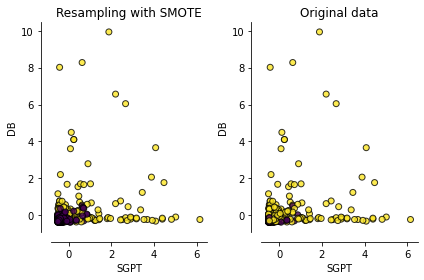

In [33]:
plot_augmented_data(X_train, y_train, ['SGPT','DB'], feature_scaler, class_balancer)

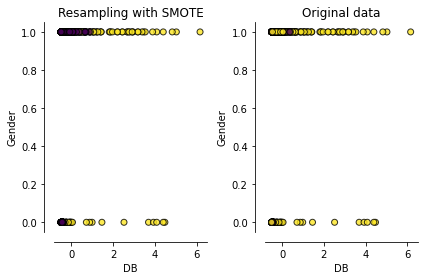

In [34]:
plot_augmented_data(X_train, y_train, ['DB','Gender'], feature_scaler, class_balancer)

###3.3 Dimensionality reduction methods<a class="anchor" id="dim_reduction_methods"></a>

####3.3.1 Principal component analysis<a class="anchor" id="pca"></a>
PCA is one of the most popular unsupervised dimensionality reduction technique that allows to reduce the dimensionality of large datasets. Is an unsupervised method since it involves only a set of features $X_1, X_2,...,X_d$ and no associated response $Y$.

It consists in making an orthogonal projection of the data onto a lower dimensional space that:
- maximizes the variance of the projected data
- minimizes the mean squared distance between data points and projections

#### Maximum variance perspective
PCA aims to find a low-dimensional representation of the data that captures as much of the information as possible. Since the variance is an indicator of the spread of the data, is possible derive PCA as a dimensionality reduction algorithm that maximizes the variance in this lower-dimensional space.
Each dimension (or principal component) found by PCA is a linear combination of the d features.
The first principal component $Z_1$ is the normalized ($\sum_{j=1}^{d} \phi_{j1}^2 = 1 $) linear combination of the orginal set of features $X_1, X_2,...,X_d$:

$ Z_1 = \phi_{11} X_1 +  \phi_{21} X_2 + ... +  \phi_{d1} X_d $

that has the largest variance.

$\phi_{1} = (\phi_{11}, \phi_{21}, ..., \phi_{d1})^T$ is the loading vector of the principal component and defines the direction in the feature space along which the data vary the most.

Given an m x d dataset $X$, to find the first principal component loading vector we need to solve the following optimization problem:

$\underset{\phi_{11}, ..., \phi_{d1}}{maximize} \ \{ \frac{1}{m} \sum_{i=1}^m \ ( \sum_{j=1}^d \phi_{j1} x_{ij} )^2 \} \ subject \ to \ \sum_{j=1}^{d} \phi_{j1}^2 = 1$ 

After the first principal component $Z_1$ is determined, the second principal component $Z_2$ is computed as the linear combination of $X_1, X_2,...,X_d$ that has the maximal variance out of all linear combinations that are uncorrelated with $Z_1$. Note that, constraining $Z_2$ to be uncorrelated with $Z_1$ is equivalent to constraining the direction of $\phi_2$ to be orthogonal to the direction of $\phi_1$.
Then, each subsequent PC computed is orthogonal to the previous ones and points in the direction of the largest variance of the residual subspace.
#### Projection perspective
PCA can be derived as an algorithm that directly minimizes the average reconstruction error.
This perspective allows to interpret PCA as a linear auto-encoder.
In detail, we found a compressed version $z$ of original data $x$ and then the compressed data can be reconstructed into $\bar{x}$ which lives in the original dimensional space:

<img src="images/pca_reconstructed_err.png" alt="pca reconstructed err" width="200"/>

The aim is to project (encoding) data onto a lower-dimensional space via an orthogonal linear mapping, while retaining as much information as possible, in such a way to minimize the distance between the original data and the reconstructed data (decoding). The mathematical optimization problem is the following:

$\underset{W \in R^{n,d}, \ U  \in R^{d,n}}{argmin} \ \ \frac{1}{m} \sum_{i=1}^m \ \lVert x_i - UW\bar{x_i}\rVert_2^2$  (Reconstruction error)

where $W \in 𝑅^{n,d}$ and $U \in 𝑅^{d,n}$ are the encoding and decoding matrices respectively.

Given a set of data points $x_1, ..., x_m \in R^d$ and let $A = X^T * X$, the solution to the problem is given by the setting:

$U = (u_1, ..., u_n)$ and $W = U^T$

where $u_1, ... u_n$ are the first n orthonormal eigenvectors of $A$ corresponding to the first n largest eigenvalues ($\lambda_1\geq, ..., \geq\lambda_n$). The sum of the remaining eigenvalues ($\lambda_{n+1}\geq, ..., \geq\lambda_d$) gives the reconstruction error.

Before applying PCA in our case study, since the features have different units, is recommended to scale them to have standard deviation equal to 1. Z-score normalization (see chapter 3.1) is applied separately on each feature of the training dataset.

In [35]:
X_train_scaled = StandardScaler().fit_transform(X_train)
pca = PCA(n_components=len(features_names), random_state=config_dict['GENERAL']['SEED'])
X_train_pca_trasformed = pca.fit_transform(X_train_scaled)

At this point, we are interested in knowing the proportion of variance explained (PVE) by each principal component, in order to understand their strength and decide how many to keep.

Given a m x d dataset $X$, the PVE for the nth principal component is given by:

$PVE =\frac{\sum_{i=1}^m{(\sum_{j=1}^{d}{\phi_{jn} \ x_{ij}})^2}}{\sum_{j=1}^d\sum_{i=1}^m \ x_{ij}^2} = \frac{variance \ explained \ by \ nth \ PC} {tot \ variance}$

To compute the cumulative PVE of the first n PCs, we can simply sum over each of the first n PVEs.
Below is plotted the scree plot showing the cumulative PVE and the PVE for each of the 10 PCs.
The graph shows that the individual variance explained by each component decreases up to the last 3 PCs which explain very few variance. Looking at the cumulative explained variance, the choice is to keep the first 7 components which explain about 0.99% of the total variance.

In [36]:
fig = prepare_PCA_explained_variance_plot(pca, template_)
'''
if config_dict['GENERAL']['SHOW_METHOD'] == 0:
  fig.show()
elif config_dict['GENERAL']['SHOW_METHOD'] == 1:
  py.iplot(fig, filename = 'explaied_variance')
elif config_dict['GENERAL']['SHOW_METHOD'] == 2:
  fig.show(renderer='svg')'''
py.iplot(fig, filename = 'explaied_variance')

In [37]:
num_components = 7

The figure below represents in a single biplot both the loading vectors and the principal component scores, which represent the positions of each observation in this new coordinate system of principal components.

From the graph is possible to observe that the projection of samples for the negative class (in blue) seems to be a bit clustered, while the positive samples in yellow are also spread toward the upper-right area of the graph.

Concerning the loading vectors, they are visualized by arrows that are under an angle and have a certain length. The angle represents the contribution of a particular feature in the direction of the PCs where it contributes. The length of the arrow depicts the strength of the contribution of the feature in that direction. By zoom in the picture we can observe the blue arrows which indicate the first 2 PC loading vectors. 

Overall we can identify 3 main groups, where each group is composed by loading vectors close to each others which indicates a correlation among them:

- Group 1: the features related to proteins (ALB, TP, AGR) 
- Group 2: the transaminases (SGPT, SGOT)
- Group 3: the total and direct bilirubina (TB, DB)

There is also a fourth group (Gender and AAP) but the strength of the loading vector related to the Gender feature is very short meaning that it scarcely influences the first two PCs (probably it will influence other PCs).

The angles of the loading vectors show that TB and DB mostly contribute to the first PC, the same happens for Gender and AAP.
Instead TP, AGR and especially ALB have arrows with great strength but there is no favorite direction toward one of the 2 components. 

In [38]:
fig = prepare_biplot(pca, X_train_pca_trasformed, y_train, features_names, template_)
'''
if config_dict['GENERAL']['SHOW_METHOD'] == 0:
  fig.show()
elif config_dict['GENERAL']['SHOW_METHOD'] == 1:
  py.iplot(fig, filename = 'bi_plot')
elif config_dict['GENERAL']['SHOW_METHOD'] == 2:
  fig.show(renderer='svg')'''
py.iplot(fig, filename = 'bi_plot')

In [39]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_matrix = pd.DataFrame(loadings[:, 0:2], columns=['PC1', 'PC2'], index=features_names)
loading_matrix

,PC1,PC2
Age,0.192074,-0.432884
Gender,0.168284,-0.013470
TB,0.776831,0.296896
DB,0.761022,0.298497
AAP,0.393975,-0.016101
SGPT,0.502412,0.601261
SGOT,0.568354,0.575830
TP,-0.480906,0.565105
ALB,-0.680054,0.659962
AGR,-0.506089,0.543042


PCA is a technique that provides a transformation of the feature space, generating meta-features. This transformation leads to the loss of information on the nature of the features and the consequent decrease in the interpretability of the ML models built. 
For this reason, in the next sections PCA will not be applied on RandomForest and DecisionTree since one of their main advantages is the interpretability and we do not want to loose this main characteristic.

####3.3.2 Empirical feature selection<a class="anchor" id="empirical_feature_selection"></a>

Alternatively, to reduce the dataset dimensionality is possible to apply an "empirical dimensionality reduction" technique which consists in removing duplicated features according to their pairwise correlation with others.

The strategy consists in performing an agglomerative hierarchical clustering with average linkage to cluster the features according to their correlation.
The process starts by creating one cluster for each feature and by computing the pairwise distance (=correlation) between all the clusters. Then, the two clusters with the highest average correlation are selected and merged. In the next iteration, the next pair of clusters with highest correlation is selected and merged. This step is repeated until we end up with one cluster. The dendogram helps to visualize the clusters.

In [40]:
fig = prepare_dendogram(X_train, title_ = "Dendrogram of clustering the features according to correlation", template_=template_)
'''
if config_dict['GENERAL']['SHOW_METHOD'] == 0:
  fig.show()
elif config_dict['GENERAL']['SHOW_METHOD'] == 1:
  py.iplot(fig, filename = 'dendogram')
elif config_dict['GENERAL']['SHOW_METHOD'] == 2:
  fig.show(renderer='svg')'''
py.iplot(fig, filename = 'dendogram')

The dendogram shows 3 main clusters highlighted in brown, green and orange.
The feature pairs which are clustered with lower distance are TB and DB (brown cluster). Also SGPT and SGOT are quite close. The orange cluster which contains AGR, TP, ALB shows a correlation but not so strong.
The choice is to remove TB and SGOT features since they are considerated as duplicates.

In [41]:
duplicated_features = ["SGOT", "TB"]
cols_without_duplicate = [x for x in features_names if x not in duplicated_features]
num_cols_without_duplicate = [x for x in cols_without_duplicate if x not in config_dict['GENERAL']['BOOLEAN_FEATURES']]
X_train_reduced = X_train[cols_without_duplicate]
X_test_reduced= X_test[cols_without_duplicate]

##4. Classification<a class="anchor" id="classification"></a>

###4.1 Metrics<a class="anchor" id="metrics"></a>
Accuracy is one of the most common metric to evaluate classification models, however it is not good when dealing with unbalanced datasets since can lead to misleading high results, even if the model performs poorly on the minority class, by simply assigning all the samples to the majority class.

In this case F1-score is used, since it takes into account not only the number of prediction errors but also the type of errors that are made. Is defined as the harmomic mean of precision and recall, where a score reaches its best value at 1 and worst score at 0.
The formula is given by:

$F1 = 2 * \frac{precision \ * \ recall}{precision \ + \ recall}$ where,

$precision = \frac{TP}{TP+FP}$ and $recall = \frac{TP}{TP+FN}$ 

F1 score gives equal weight to Precision and Recall and is used in the context of this project as main performance evaluation metric and during the grid search for tuning the model hyperparameters.

###4.2 Cross validation<a class="anchor" id="cv"></a>
K-fold cross validation is a technique used to estimate model performance, making predictions on data unseen during training.
It results in a less biased or less optimistic estimate of the model skill than other methods, such as a simple train/test split.
However when using a single K-fold cross validation procedure for both tune and select the model, this can still lead to a optimistically biased evaluation of the performance.

The approach used to limit this problem, is to nest the hyperparameter optimization procedure under the model selection, using the so called Nested Cross Validation technique. Two main resampling loops are generated:
- outer resampling loop (evaluate model performance): consists in a Stratified 10-fold Cross-Validation procedure which involves fitting the best model found in the inner loop using all folds but one (" cv training set") and evaluating it on the holdout fold (" cv test set") by computing the F1 score. 
- inner resampling loop (best hyperparameters search): consists in taking the " cv training dataset" provided by the outer loop and perform a hyperparameter optimized procedure (grid search) using a Stratified 5-fold Cross-Validation that finds an optimal set of hyperparameters for the model. 

The final F1 score is computed by averaging the scores of each outer resampling iteration.

This procedure is applied on several classifiers and the one which gives the best result is selected as final model.
The final model is configured and fit by applying a grid search (Stratified 5-fold cv) fo hyperparameters optimization, considering the entire training dataset as input. Then, the hyperparameters found during this final search are used to configure a final model. The final model is fit on the entire training dataset and evaluated on the test dataset (see section 1.5 for data splits).

The cross validation procedure is handled through a pipeline which is made up of the following steps:

- Feature scaling: fit is performed exclusively on the training dataset (to prevent any information leakages) and then the transformation is applied also on the test dataset (see section 3.1).
- Rebalaning: is done only on training data and not on the test dataset because we do not want to alter its original class distribution (see section 3.2).
- PCA: fit is performed exclusively on the training dataset (to prevent any information leakages) and then the transformation is applied also on the test dataset (see section 3.3.1).


In [131]:
config_dict['CLASSIFICATION']['MODELS'] = {
        'LinearSVC': svm.SVC(kernel='linear'),
        'RbfSVC': svm.SVC(kernel='rbf'),
        'KNN': neighbors.KNeighborsClassifier(),
        'LogisticRegression': linear_model.LogisticRegression(),
        'DecisionTree': tree.DecisionTreeClassifier(),
        'RandomForest': ensemble.RandomForestClassifier(),
}

config_dict['CLASSIFICATION']['GENERAL'] = {
    'score_metric': 'f1',
    'cv_inner': 5,
    'cv_outer': 10,
    'seed': config_dict['GENERAL']['SEED']
}

config_dict['CLASSIFICATION']['PARAMS'] = {
    'KNN': {
            'KNN__n_neighbors' : list(range(3,25, 2)), 
            'KNN__weights': ['uniform', 'distance' ],
            'KNN__p': [1, 2],
            #'KNN__n_jobs' : [-1],
            },
    'LinearSVC': {
            'LinearSVC__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
            #'LinearSVC__kernel': ['linear'],  
            },
    'RbfSVC': {
            'RbfSVC__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  
            'RbfSVC__gamma': [0.0001, 0.001, 0.01, 0.1, 1],    
            #'RbfSVC__kernel': ['rbf'],
            },
    'LogisticRegression': {
            'LogisticRegression__penalty': ['l1', 'l2'],
            'LogisticRegression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],   
            'LogisticRegression__max_iter': [1000],
            'LogisticRegression__solver': ['liblinear'],
            },
    'DecisionTree': {
            'DecisionTree__max_depth': list(range(2, 10)),
            'DecisionTree__min_samples_split': list(range(2, 10)),
            'DecisionTree__criterion' : ['gini', 'entropy'],
            
            },
    'RandomForest': {
            'RandomForest__n_estimators': [10, 100],
            'RandomForest__criterion' : ['gini', 'entropy'],
            'RandomForest__max_depth': list(range(2, 10)),
            'RandomForest__min_samples_split': [2, 5, 10], 
            'RandomForest__max_features': ['sqrt'],
            #'RandomForest__n_jobs' : [-1],
            },
}

show_dict(config_dict)

{'CLASSIFICATION': {'BALANCER': {'SMOTENC': SMOTENC(categorical_features=[9], random_state=42,
        sampling_strategy='not majority')},
                    'GENERAL': {'cv_inner': 5,
                                'cv_outer': 10,
                                'score_metric': 'f1',
                                'seed': 42},
                    'MODELS': {'DecisionTree': DecisionTreeClassifier(),
                               'KNN': KNeighborsClassifier(),
                               'LinearSVC': SVC(kernel='linear'),
                               'LogisticRegression': LogisticRegression(),
                               'RandomForest': RandomForestClassifier(),
                               'RbfSVC': SVC()},
                    'PARAMS': {'DecisionTree': {'DecisionTree__criterion': ['gini',
                                                                            'entropy'],
                                                'DecisionTree__max_depth': [2,
                  

In [43]:
classifiers = []

###4.3 Support vector machines
Support vector machine is a non probabilistic binary linear classifier, which aims to find the "best" hyperplane $<\boldsymbol{w},\boldsymbol{x}>+b$ or a set to hyperplanes in a high dimensional space, able to discriminate among the two classes.
The "best" hyperplane is the one which gives the largest margin among the two distributions that we want to separate, where the margin indicates the minimal distance from the observations to the hyperplane.
The points that are on the margin are called support vectors and the maximal margin hyperplane depends directly on them. This means that the SVM is a classifier that regardless how many data we have, compresses its memory, because it saves only a subset of points. 

The simpler version is the Maximal Margin Classifier (or Hard/Large Margin Classifier) which requires that the classes be separable by a linear boundary. The reason of the expression hard is because the formulation does not allow for any violation of the margin condition.
Considering a dataset $\{(x_1, y_1), ..., (x_N, y_N)\}$, the objective is defined by a single constrained optimization problem:

$\underset{w, b, r}{max} \ r$  

subject to $y_n(<\boldsymbol{w},\boldsymbol{x_n}>+b) \geq r, \ \lVert w \rVert = 1, \ r>0$

which says that we want to maximize the margin r, considering normalized weights, while ensuring that data lies on the correct side of the hyperplane.

This is equivalent to scaling the data such that the margin is unity:

$\underset{w, b}{min} \ \frac{1}{2} \lVert w \rVert^2$ 

subject to $y_n(<\boldsymbol{w},\boldsymbol{x_n}>+b) \geq 1$

In the case where we have data that are not perfectly linearly separable, we can allow for some misclassifications by simply letting some examples to fall within the margin region, or even to be on the wrong side of the hyperplane. This model is called Soft Margin  Classifier.
In this case the mathematic formulation is the following:

$\underset{w, b, \varepsilon}{min} \ \frac{1}{2} \lVert w \rVert^2 +C\sum_{n=1}^N \varepsilon_n$ 

subject to $y_n(<\boldsymbol{w},\boldsymbol{x_n}>+b) \geq 1 - \varepsilon_n, \ \varepsilon_n \geq 0$

where $\varepsilon_n$ is the so called slack variable, which allows a particular example to be within the margin or even on the wrong side of the hyperplane and $C$ is a regularization term which trades off the size of the margin and the total amount of slack that we have.

To deal with the case of classes which are heavily not linearly separable, non-linear SVMs have been developed.
The general idea is to find a transformation $\phi$ that maps the data into a higher dimensional space linearly separable. However, training the SVM in this higher dimensional space is computationally unfeasible and also often domain experts are needed to define the trasformation. 
Instead of explicitly defining a non-linear feature map $\phi$  and computing the resulting inner product between examples $x_i$ and $x_j$, we can use a kernel function $K(\boldsymbol{x_i}, \boldsymbol{x_j})$ defined as following, which implicitly defines a non-linear mapping:

 $K(\boldsymbol{x}, \boldsymbol{x'}) = <\phi(\boldsymbol{x}), \phi(\boldsymbol{x'})>_M$ 

where $x, x' \ \epsilon \ R^N$, $<…>_M$ is the inner product in $𝑅^M$ and $\phi(x)$ is the transformation function that maps $x$ from $𝑅^N$ to $𝑅^M$. 
This generalization from inner product to a kernel function is known as kernel trick, as it hides the explicit non-linear feature map.
Some of the most common used kernels are the following:

- Linear kernel: $<x, x'>$ 

- Polynomial kernel: $(<x,x'> + c)^d, c\geq 0, d \ \epsilon \ \mathbb{N} $
, where $\gamma$ defines how far the influence of a single training example reaches.
- Gaussian Rbf kernel: $e^{(-\gamma \lVert x-x' \rVert^2)}$

Once the model is trained, a test observation is classified based on which side of the hyperplane it lies.

**Experiments setting and results:**

Concerning the SVM classifiers, we try different data and kernel settings:

- 1) Linear kernel (with PCA)
- 2) Linear kernel (with all features)
- 3) Linear kernel (with reduced features)
- 4) Rbf kernel (with PCA)
- 5) Rbf kernel (with all featuers)

Below the hyperparameters setting:

In [ ]:
display(pd.DataFrame(config_dict['CLASSIFICATION']['PARAMS']['LinearSVC'], columns = ['LinearSVC__C']).T)
display(pd.DataFrame(config_dict['CLASSIFICATION']['PARAMS']['RbfSVC'], columns = ['RbfSVC__C']).T)
display(pd.DataFrame(config_dict['CLASSIFICATION']['PARAMS']['RbfSVC'], columns = ['RbfSVC__gamma']).T)

,0,1,2,3,4,5,6
LinearSVC__C,0.001,0.01,0.1,1.0,10.0,100.0,1000.0


,0,1,2,3,4,5,6
RbfSVC__C,0.001,0.01,0.1,1.0,10.0,100.0,1000.0


,0,1,2,3,4
RbfSVC__gamma,0.0001,0.001,0.01,0.1,1.0


####4.3.1 Linear kernel (with PCA)

Nested cross validation results:

Below are reported the training and validation F1 scores (mean value and standard deviation), obtained by averaging over the F1 scores of the outer loop in the nested cross-validation procedure, together with the list of best hyperparameters found on each inner loop. We can observe that the C parameter is not very stable among the iterations.

In [ ]:
linear_svm_classifier_pca = Classifier('LinearSVC', config_dict['CLASSIFICATION']['MODELS']['LinearSVC'], 
                                       config_dict['CLASSIFICATION']['GENERAL'], 
                                       config_dict['CLASSIFICATION']['PARAMS']['LinearSVC'], 
                                       class_balancer, 
                                       feature_scaler)
file_name = f'{linear_svm_classifier_pca.name}_PCA.pkl'

if config_dict['GENERAL']['PERFORM_NCV']:
  linear_svm_pca_mean_score, linear_svm_pca_std_score = linear_svm_classifier_pca.nested_cv(X_train, y_train, apply_PCA=True, num_components=num_components)
  save(linear_svm_classifier_pca, os.path.join(MODELS_DIRPATH, file_name))
else:
  linear_svm_classifier_pca = load(os.path.join(MODELS_DIRPATH, file_name))
  linear_svm_classifier_pca.print_nested_cv_results()

linear_svm_classifier_pca.cv(X_train, X_test, y_train, y_test, apply_PCA=True, print_res=False)
classifiers.append((linear_svm_classifier_pca, "PCA"))

Mean training F1-score = 0.64 (0.01)
Mean validation F1-score = 0.63 (0.09)

List of best hyperparameters to check stability: 


,0,1,2,3,4,5,6,7,8,9
LinearSVC__C,1,100,10,10,1,1,10,1,1000,10


####4.3.2 Linear kernel (with all features)


Nested cross validation results:

In this case we do not obtain substantial differences with respect to the linear kernel training setting with PCA:

In [ ]:
linear_svm_classifier = Classifier('LinearSVC', config_dict['CLASSIFICATION']['MODELS']['LinearSVC'], 
                                   config_dict['CLASSIFICATION']['GENERAL'], 
                                   config_dict['CLASSIFICATION']['PARAMS']['LinearSVC'], 
                                   class_balancer, 
                                   feature_scaler)
file_name = f'{linear_svm_classifier.name}.pkl'

if config_dict['GENERAL']['PERFORM_NCV']:
  linear_svm_mean_score, linear_svm_std_score = linear_svm_classifier.nested_cv(X_train, y_train, apply_PCA=False)
  save(linear_svm_classifier, os.path.join(MODELS_DIRPATH, file_name))
else:
  linear_svm_classifier = load(os.path.join(MODELS_DIRPATH, file_name))
  linear_svm_classifier.print_nested_cv_results()

linear_svm_classifier.cv(X_train, X_test, y_train, y_test, apply_PCA=False, print_res=False)
classifiers.append((linear_svm_classifier, "All features"))

Mean training F1-score = 0.64 (0.01)
Mean validation F1-score = 0.62 (0.09)

List of best hyperparameters to check stability: 


,0,1,2,3,4,5,6,7,8,9
LinearSVC__C,10,100,10,1,100,1,1,10,10,1


####4.3.3 Linear Kernel (Reduced features)

Nested cross-validation results:

With this setting we can observe a slight decrease in the Mean validation F1-score. This setting refers to the empirical feature selection technique explained in section 3.3.2, where we removed the featuers **SGOT** and **TB**, since they are considered as duplicates.

In [ ]:
feature_scaler_red = ColumnTransformer(remainder='passthrough',
                                       transformers=[("standardscaler", StandardScaler(), num_cols_without_duplicate)],
                                       verbose_feature_names_out=False)

feature_scaler1 = clone(feature_scaler_red)
_ = feature_scaler1.fit_transform(X_train_reduced) # to retreive the categorical features indices (order of columns is modified by the scaler)

#set categorical features indices
class_balancer_red = config_dict['CLASSIFICATION']['BALANCER']['SMOTENC'].set_params(categorical_features=[i for i, f in enumerate(feature_scaler1.get_feature_names_out()) if f in config_dict['GENERAL']['BOOLEAN_FEATURES']])

linear_svm_classifier_red = Classifier('LinearSVC', 
                                       config_dict['CLASSIFICATION']['MODELS']['LinearSVC'], 
                                       config_dict['CLASSIFICATION']['GENERAL'], 
                                       config_dict['CLASSIFICATION']['PARAMS']['LinearSVC'], 
                                       class_balancer_red, 
                                       feature_scaler_red)
file_name = f'{linear_svm_classifier_red.name}_red.pkl'

if config_dict['GENERAL']['PERFORM_NCV']:
  linear_svm_red_mean_score, linear_svm_red_std_score = linear_svm_classifier_red.nested_cv(X_train_reduced, y_train, apply_PCA=False)
  save(linear_svm_classifier_red, os.path.join(MODELS_DIRPATH, file_name))
else:
  linear_svm_classifier_red = load(os.path.join(MODELS_DIRPATH, file_name))
  linear_svm_classifier_red.print_nested_cv_results()

linear_svm_classifier_red.cv(X_train_reduced, X_test_reduced, y_train, y_test, apply_PCA=False, print_res=False)
classifiers.append((linear_svm_classifier_red, "Reduced features"))

Mean training F1-score = 0.64 (0.01)
Mean validation F1-score = 0.61 (0.09)

List of best hyperparameters to check stability: 


,0,1,2,3,4,5,6,7,8,9
LinearSVC__C,10,10,100,100,100,100,100,1,100,1


**Linear kernel results**

At this point we train the linear kernel with PCA, which is the best model found until now (mean F1-score = 0.63), on the entire training set. By performing grid search, with stratified 5-fold cross validation (see section 4.2), we obtain $C = 1000$ as best hyperparameter.
Then we test the trained model on the test data set. Below the results obtained:

>> Predicting on test dataset...
Best hyperparameters:


,LinearSVC__C
0,1000



Test classification report
              precision    recall  f1-score   support

           0       0.46      0.91      0.61        34
           1       0.94      0.57      0.71        83

    accuracy                           0.67       117
   macro avg       0.70      0.74      0.66       117
weighted avg       0.80      0.67      0.68       117



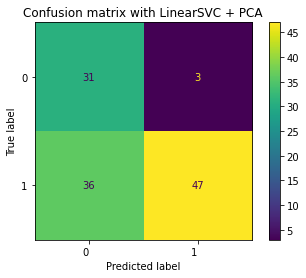

In [ ]:
linear_svm_classifier_pca.cv(X_train, X_test, y_train, y_test, apply_PCA=True, num_components=num_components)

We can focus on the recall of the positive class, i.e. *Liver Patient*, which is very relevant in a medical context since a high recall succeeds well in finding all the positive cases in the data, even though they may also wrongly identify some negative cases as positive cases. In this case the recall for the positive class is very low (57%) which is not good.  

Then, we plot for visualization purposes the decision boundary of the Linear SVC with respect to the test samples, considering 2 of the most interesting features found in section 2.3. We observe that the model is able to find a linear decision boundary but it is not so good in separating the 2 classes since there are many misclassifications.

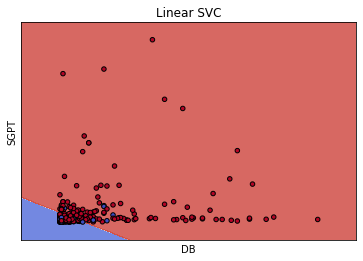

In [ ]:
params = linear_svm_classifier.best_model.named_steps[linear_svm_classifier.name].get_params()

plot_2D_svm_decision_boundary_wrap(X_train, y_train, X_test, y_test, svm.SVC(**params), 
                              features_pair=['DB','SGPT'], title="Linear SVC", apply_PCA=False)

####4.3.3.4 Rbf kernel (with PCA)

Nested cross validation results:

In this setting the $\gamma$ value remains stable among all the inner loops to the value 1, while the C parameter for most iterations assumes the value of 0.001.
With respect to the best model found with linear kernel (mean F1-score = 0.63), the Rbf kernel gives better results (mean F1-score = 0.78).

In [ ]:
rbf_svm_classifier_pca = Classifier('RbfSVC', config_dict['CLASSIFICATION']['MODELS']['RbfSVC'], 
                            config_dict['CLASSIFICATION']['GENERAL'], 
                            config_dict['CLASSIFICATION']['PARAMS']['RbfSVC'], 
                            class_balancer, 
                            feature_scaler)

file_name = f'{rbf_svm_classifier_pca.name}_PCA.pkl'

if config_dict['GENERAL']['PERFORM_NCV']:
  rbf_svm_mean_score_pca, rbf_svm_std_score_pca = rbf_svm_classifier_pca.nested_cv(X_train, y_train, apply_PCA=True, num_components=num_components)
  save(rbf_svm_classifier_pca, os.path.join(MODELS_DIRPATH, file_name))
else:
  rbf_svm_classifier_pca = load(os.path.join(MODELS_DIRPATH, file_name))
  rbf_svm_classifier_pca.print_nested_cv_results()

rbf_svm_classifier_pca.cv(X_train, X_test, y_train, y_test, apply_PCA=True, print_res=False)
classifiers.append((rbf_svm_classifier_pca, "PCA"))

Mean training F1-score = 0.82 (0.01)
Mean validation F1-score = 0.78 (0.02)

List of best hyperparameters to check stability: 


,0,1,2,3,4,5,6,7,8,9
RbfSVC__C,0.1,0.1,0.001,0.1,0.1,0.001,0.001,0.001,0.001,0.001
RbfSVC__gamma,1.0,1.0,1.000,1.0,1.0,1.000,1.000,1.000,1.000,1.000


####4.3.3.5 Rbf kernel (with all features)

Nested-cross validation results:

Without applying PCA we obtain a slight lower result (mean F1 score = 0.76), but there are no substantial differences.

In [ ]:
rbf_svm_classifier = Classifier('RbfSVC', config_dict['CLASSIFICATION']['MODELS']['RbfSVC'], 
                            config_dict['CLASSIFICATION']['GENERAL'], 
                            config_dict['CLASSIFICATION']['PARAMS']['RbfSVC'], 
                            class_balancer, 
                            feature_scaler)

file_name = f'{rbf_svm_classifier.name}.pkl'

if config_dict['GENERAL']['PERFORM_NCV']:
  rbf_svm_mean_score, rbf_svm_std_score = rbf_svm_classifier.nested_cv(X_train, y_train, apply_PCA=False)
  save(rbf_svm_classifier, os.path.join(MODELS_DIRPATH, file_name))
else:
  rbf_svm_classifier = load(os.path.join(MODELS_DIRPATH, file_name))
  rbf_svm_classifier.print_nested_cv_results()

rbf_svm_classifier.cv(X_train, X_test, y_train, y_test, apply_PCA=False, print_res=False)
classifiers.append((rbf_svm_classifier, "All Features"))

Mean training F1-score = 0.84 (0.05)
Mean validation F1-score = 0.76 (0.04)

List of best hyperparameters to check stability: 


,0,1,2,3,4,5,6,7,8,9
RbfSVC__C,0.1,0.1,0.001,0.1,0.1,0.001,0.001,0.001,0.001,10.0
RbfSVC__gamma,1.0,1.0,1.000,1.0,1.0,1.000,1.000,1.000,1.000,1.0


**Rbf kernel results:**

Now we train the Rbf kernel with PCA, which is the best model found until now (mean F1-score = 0.78), on the entire training set. By performing grid search, with stratified 5-fold cross validation (see section 4.2), we obtain $C = 0.001$  and $\gamma = 1$ as best hyperparameters.
Then we test the trained model on the test data set. Below the results obtained:

>> Predicting on test dataset...
Best hyperparameters:


,RbfSVC__C,RbfSVC__gamma
0,0.001,1



Test classification report
              precision    recall  f1-score   support

           0       0.57      0.47      0.52        34
           1       0.80      0.86      0.83        83

    accuracy                           0.74       117
   macro avg       0.68      0.66      0.67       117
weighted avg       0.73      0.74      0.74       117



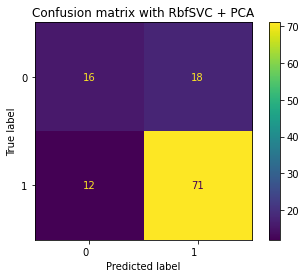

In [ ]:
rbf_svm_classifier_pca.cv(X_train, X_test, y_train, y_test, apply_PCA=True)

With respect to the linear kernel, with the Rbf kernel we obtain a higher f1 score (0.83 versus 0.71) and a higher recall (0.86 versus 0.57) on the positive class. However the metrics on the negative class are low, indeed, only 16 over 34 samples are correctly classified for the negative class.

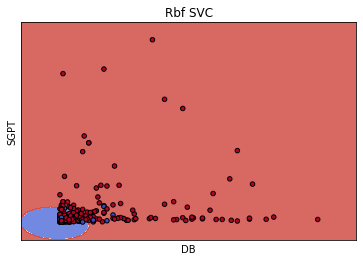

In [ ]:
params = rbf_svm_classifier.best_model.named_steps[rbf_svm_classifier.name].get_params()

plot_2D_svm_decision_boundary_wrap(X_train, y_train, X_test, y_test, svm.SVC(**params), 
                              features_pair=['DB','SGPT'], title="Rbf SVC", apply_PCA=False)

The decision boundary, as expected, is a non linear surface. Again, we have many misclassifications for both classes.

###4.4 KNN
K Nearest Neighbors is a non-parametric technique and is one of the simplest machine learning algorithms.
Is based on the idea of memorizing the training data and then to predict the label of any new instance on the basis of the labels of its closest neighbor data in the training set.
The assumption is that the features used to describe the data points are relevant in the labeling process since they make close points likely to have the same label.

KNN does not require training phase, but requires at inference time to compute the distance between the test point and all the training points, meaning that it's time consuming and computationally intensive at inference time.

Given the training examples $\{x_i, y_i\}$ and a test point $x$ that we want to classify, the algorithm is based on the following main steps:

- compute the distance $D(x, x_i)$ to every training sample $x_i$
- select K closest instances $x_{i1}, ..., x_{iK}$ and their labels $y_{i1}, ..., y_{iK}$ 
- output the class y* which is most frequent in $y_{i1}, ..., y_{iK}$ 

The distance measure D is a key component of the algorithm since it defines which examples are similar and which aren't.
The most general metric used to compute the distance is based on the Minkowski distance:

$L_p(x,y) = (\sum_{i=1}^d | x_i - y_i|^p)^{\frac{1}{p}}$ 

where, 

when p = 1, this is equivalent to using Manhattan distance (l1), and Euclidean distance (l2) for p = 2. 

Another aspect to take into consideration is the weight function used in prediction. Possible values are:

- uniform: all points in each neighborhood are weighted equally

- distance: points are weighted by the inverse of their distance, meaning that closer neighbors of a test point will have a greater influence than neighbors which are further away.

Finally, the value of K is the core deciding factor and has strong effect on KNN performances. For large values of K, everything is classified as the most probable class, while small values lead to unstable decision boundaries.


**Experiments setting and results:**

Concerning the KNN classifiers, we try 2 different data settings:

- 1) KNN (with PCA)
- 2) KNN (with all features)

Below the parameters setting:

In [ ]:
display(pd.DataFrame(config_dict['CLASSIFICATION']['PARAMS']['KNN'], columns = ['KNN__n_neighbors']).T)
display(pd.DataFrame(config_dict['CLASSIFICATION']['PARAMS']['KNN'], columns = ['KNN__weights']).T)
display(pd.DataFrame(config_dict['CLASSIFICATION']['PARAMS']['KNN'], columns = ['KNN__p']).T)

,0,1,2,3,4,5,6,7,8,9,10
KNN__n_neighbors,3,5,7,9,11,13,15,17,19,21,23


,0,1
KNN__weights,uniform,distance


,0,1
KNN__p,1,2


####4.4.1 KNN (with PCA)

Nested-cross validation results:

The results show that the mean training F1-score (0.98) is considerably higher than mean validation F1-score (0.66), suggesting that the model may be overfitting the training data.
The parameters choice in the inner loop is quite stable, among the different iterations, to the values of K = 3, p = 2 (Euclidean Distance) and weights equal to distance.

In [ ]:
knn_classifier_pca = Classifier('KNN', config_dict['CLASSIFICATION']['MODELS']['KNN'], 
                            config_dict['CLASSIFICATION']['GENERAL'], 
                            config_dict['CLASSIFICATION']['PARAMS']['KNN'], 
                            class_balancer, 
                            feature_scaler)
file_name = f'{knn_classifier_pca.name}_PCA.pkl'

if  config_dict['GENERAL']['PERFORM_NCV']:
  knn_mean_score_pca, knn_std_score_pca = knn_classifier_pca.nested_cv(X_train, y_train, apply_PCA=True, num_components=num_components)
  save(knn_classifier_pca, os.path.join(MODELS_DIRPATH, file_name))
else:
  knn_classifier_pca = load(os.path.join(MODELS_DIRPATH, file_name))
  knn_classifier_pca.print_nested_cv_results()

knn_classifier_pca.cv(X_train, X_test, y_train, y_test, apply_PCA=True, print_res=False)
classifiers.append((knn_classifier_pca, "PCA"))

Mean training F1-score = 0.98 (0.06)
Mean validation F1-score = 0.66 (0.06)

List of best hyperparameters to check stability: 


,0,1,2,3,4,5,6,7,8,9
KNN__n_neighbors,3,3,3,3,3,3,5,3,3,3
KNN__p,1,2,2,2,2,2,2,2,2,1
KNN__weights,distance,distance,distance,distance,distance,distance,uniform,distance,distance,distance


####4.4.2 KNN (with all features)

Nested-cross validation results:

Concering the training with all the features, we obtain a slight decrease in performance, both on training and validation mean F1-scores.
In this case, the distance measure most selected in the inner loops is the Manhattan Distance (p=1).

In [ ]:
knn_classifier = Classifier('KNN', config_dict['CLASSIFICATION']['MODELS']['KNN'], 
                            config_dict['CLASSIFICATION']['GENERAL'], 
                            config_dict['CLASSIFICATION']['PARAMS']['KNN'], 
                            class_balancer, 
                            feature_scaler)
file_name = f'{knn_classifier.name}.pkl'

if  config_dict['GENERAL']['PERFORM_NCV']:
  knn_mean_score, knn_std_score = knn_classifier.nested_cv(X_train, y_train, apply_PCA=False)
  save(knn_classifier, os.path.join(MODELS_DIRPATH, file_name))
else:
  knn_classifier = load(os.path.join(MODELS_DIRPATH, file_name))
  knn_classifier.print_nested_cv_results()

knn_classifier.cv(X_train, X_test, y_train, y_test, apply_PCA=False, print_res=False)
classifiers.append((knn_classifier, "All features"))

Mean training F1-score = 0.95 (0.08)
Mean validation F1-score = 0.65 (0.05)

List of best hyperparameters to check stability: 


,0,1,2,3,4,5,6,7,8,9
KNN__n_neighbors,3,3,3,3,3,3,5,3,3,3
KNN__p,1,2,1,1,1,1,1,2,1,1
KNN__weights,distance,distance,distance,uniform,distance,distance,uniform,distance,uniform,distance


**KNN results:**

Now we train the KNN with PCA, which is the best model found (mean F1-score = 0.66), on the entire training set. By performing grid search, with stratified 5-fold cross validation (see section 4.2), we obtain K = 5, p = 2 and weights = distance as best parameters.
Then we test the trained model on the test data set. Below the results obtained:

>> Predicting on test dataset...
Best hyperparameters:


,KNN__n_neighbors,KNN__p,KNN__weights
0,5,2,distance



Test classification report
              precision    recall  f1-score   support

           0       0.43      0.68      0.53        34
           1       0.83      0.64      0.72        83

    accuracy                           0.65       117
   macro avg       0.63      0.66      0.62       117
weighted avg       0.71      0.65      0.67       117



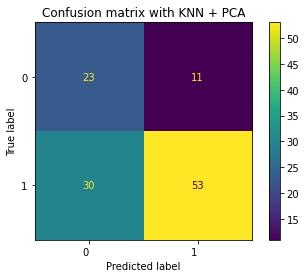

In [ ]:
knn_classifier_pca.cv(X_train, X_test, y_train, y_test, apply_PCA=True)

The recall for the positive class in this case is a bit higher (0.64)  with respect to the one found with the Linear SVM (0.57), but still not acceptable and lower with respect to the one found with the Rbf SVM (0.86).
Also the precision for the negative class is very low, indeed it detects many negatives samples that aren’t actually negative.

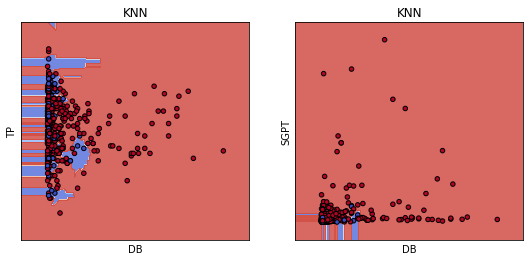

In [ ]:
params = knn_classifier.best_model.named_steps[knn_classifier.name].get_params()

plot_2D_svm_decision_boundary_wrap(X_train, y_train, X_test, y_test, neighbors.KNeighborsClassifier(**params), 
                                   features_pair=['DB','TP'], title="KNN", apply_PCA=False, features_pair2=['DB','SGPT'])

By looking at the decision boundaries above we can see that the model is overfitting, since the regions that separate the classes are often located around few or isolated points.

###4.5 Logistic Regression
The Logistic Regression is a linear model for classification which models the probability that the response variable $Y$ belongs to a particular category, using the logistic function.

Assuming that the target $Y$ takes values in the set $\{0,1\}$, if we define $X$ as the d-dimensional feature vector of a given sample and $\beta_0,\beta=(\beta_1,...,\beta_d)^T$ as the model parameters, then the Logistic Regression predicts the probability of the positive class $Pr(Y=1|X)$ as:

$ p(X)  = \frac{e^{\beta_0+\beta_1X_1 + ...\beta_dX_d}}{1 + e^{\beta_0+\beta_1X_1 + ...\beta_dX_d}} = \frac{1}{1 + e^{-(\beta_0+\beta_1X_1 + ...\beta_dX_d)}}$

The function gives always outputs between 0 and 1, producing a S-shape curve.

As an optimization problem, we want to minimize the following log-likelihood:

$ \underset{\beta}{min} \ C \ (\sum_{i=1}^n - \ y_i log(p(x_i)) - (1-y_i) log(1-p(x_i))) + r(\beta)$ 

where n is the number of training points, $r(\beta)$ is the regularization term and $C$ is the inverse of the regularization strength.

Some possible choices for the regularization term $r(\beta)$ are the following:

- $l1 = \lVert\beta\rVert_1$

- $l2 = \frac{1}{2}\lVert\beta\rVert_2^2$

Concerning the Logistic Regression, we try 2 different data settings:

- 1) Logistic Regression (with PCA)
- 2) Logistic Regression (with all features)

Below the hyperparameters setting:

In [ ]:
display(pd.DataFrame(config_dict['CLASSIFICATION']['PARAMS']['LogisticRegression'], columns = ['LogisticRegression__penalty']).T)
display(pd.DataFrame(config_dict['CLASSIFICATION']['PARAMS']['LogisticRegression'], columns = ['LogisticRegression__C']).T)
display(pd.DataFrame(config_dict['CLASSIFICATION']['PARAMS']['LogisticRegression'], columns = ['LogisticRegression__max_iter']).T)
display(pd.DataFrame(config_dict['CLASSIFICATION']['PARAMS']['LogisticRegression'], columns = ['LogisticRegression__solver']).T)

,0,1
LogisticRegression__penalty,l1,l2


,0,1,2,3,4,5,6
LogisticRegression__C,0.001,0.01,0.1,1.0,10.0,100.0,1000.0


,0
LogisticRegression__max_iter,1000


,0
LogisticRegression__solver,liblinear


The algorithm chosen in the optimization problem is "liblinear", which is a coordinate descent (CD) algorithm suitable for small datasets and supporting both l1 and l2 penalties.

####4.5.1 Logistic Regression (with PCA)

Nested cross validation results:

Logistic regression with PCA leads to a validation score which is close to the training score, however the reached score is quite low (0.67 on the validation).
In this case we can notice a variability in the selection of the C parameter, while the penalty is fixed to l1 for all the interations.

In [ ]:
logistic_classifier_pca = Classifier('LogisticRegression', config_dict['CLASSIFICATION']['MODELS']['LogisticRegression'], 
                            config_dict['CLASSIFICATION']['GENERAL'], 
                            config_dict['CLASSIFICATION']['PARAMS']['LogisticRegression'], 
                            class_balancer, 
                            feature_scaler)
file_name = f'{logistic_classifier_pca.name}_PCA.pkl'

if config_dict['GENERAL']['PERFORM_NCV']:
  logistic_mean_score_pca, logistic_std_score_pca = logistic_classifier_pca.nested_cv(X_train, y_train, apply_PCA=True, num_components=num_components)
  save(logistic_classifier_pca, os.path.join(MODELS_DIRPATH, file_name))
else:
  logistic_classifier_pca = load(os.path.join(MODELS_DIRPATH, file_name))
  logistic_classifier_pca.print_nested_cv_results()

logistic_classifier_pca.cv(X_train, X_test, y_train, y_test, apply_PCA=True, print_res=False)
classifiers.append((logistic_classifier_pca, "PCA"))

Mean training F1-score = 0.69 (0.01)
Mean validation F1-score = 0.67 (0.07)

List of best hyperparameters to check stability: 


,0,1,2,3,4,5,6,7,8,9
LogisticRegression__C,10.0,0.01,10.0,100.0,100.0,100.0,0.01,100.0,1.0,0.01
LogisticRegression__max_iter,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
LogisticRegression__penalty,l1,l1,l1,l1,l1,l1,l1,l1,l1,l1
LogisticRegression__solver,liblinear,liblinear,liblinear,liblinear,liblinear,liblinear,liblinear,liblinear,liblinear,liblinear


####4.5.2 Logistic regression (with all features)

Nested cross validation results:

Concerning the training with all the features we can notice a variability in the selection of both C and penalty parameters.

In [ ]:
logistic_classifier = Classifier('LogisticRegression', config_dict['CLASSIFICATION']['MODELS']['LogisticRegression'], 
                                 config_dict['CLASSIFICATION']['GENERAL'], 
                                 config_dict['CLASSIFICATION']['PARAMS']['LogisticRegression'], 
                                 class_balancer, 
                                 feature_scaler)
file_name = f'{logistic_classifier.name}.pkl'

if config_dict['GENERAL']['PERFORM_NCV']:
  logistic_mean_score, logistic_std_score = logistic_classifier.nested_cv(X_train, y_train, apply_PCA=False)
  save(logistic_classifier, os.path.join(MODELS_DIRPATH, file_name))
else:
  logistic_classifier = load( os.path.join(MODELS_DIRPATH, file_name))
  logistic_classifier.print_nested_cv_results()

logistic_classifier.cv(X_train, X_test, y_train, y_test, apply_PCA=False, print_res=False)
classifiers.append((logistic_classifier, "All features"))

Mean training F1-score = 0.7 (0.01)
Mean validation F1-score = 0.67 (0.05)

List of best hyperparameters to check stability: 


,0,1,2,3,4,5,6,7,8,9
LogisticRegression__C,1,1,100,100,10,1000,1,1,1,10
LogisticRegression__max_iter,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
LogisticRegression__penalty,l1,l2,l1,l1,l2,l1,l1,l2,l2,l2
LogisticRegression__solver,liblinear,liblinear,liblinear,liblinear,liblinear,liblinear,liblinear,liblinear,liblinear,liblinear


**Logistic regression results:**

At this point the choice is to train the KNN with PCA (there are no evident differences between the model trained with PCA and the one trained will all the features) on the entire training set. By performing grid search, with stratified 5-fold cross validation (see section 4.2), we obtain C = 100 and penalty = l1.
Then we test the trained model on the test data set. Below the results obtained:

>> Predicting on test dataset...
Best hyperparameters:


,LogisticRegression__C,LogisticRegression__max_iter,LogisticRegression__penalty,LogisticRegression__solver
0,100,1000,l1,liblinear



Test classification report
              precision    recall  f1-score   support

           0       0.52      0.88      0.65        34
           1       0.93      0.66      0.77        83

    accuracy                           0.73       117
   macro avg       0.72      0.77      0.71       117
weighted avg       0.81      0.73      0.74       117



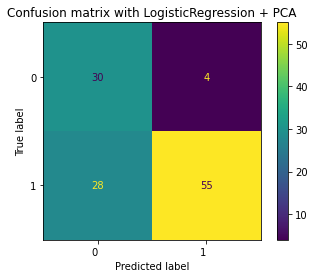

In [ ]:
logistic_classifier_pca.cv(X_train, X_test, y_train, y_test, apply_PCA=True)

This time the model gives a good precision (0.93) on the positive class, but a low recall (0.66). Indeed, there are 28 positives out of 83 that are not correctly detected by the model, but only 4 negative points out of 34 are wrongly classified as positives.

The figure below shows the decision boundary found by training the logistic regression considering only the features DB and SGPT and by applying PCA. Also for this model the linear boundary obtained considering PC1 and PC2 is not able to well separate the 2 classes.

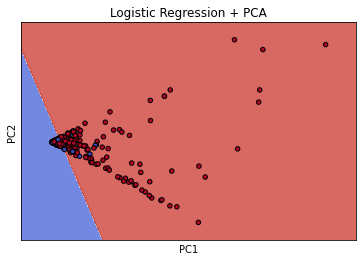

In [ ]:
params = logistic_classifier_pca.best_model.named_steps[logistic_classifier_pca.name].get_params()

plot_2D_svm_decision_boundary_wrap(X_train, y_train, X_test, y_test, linear_model.LogisticRegression(**params), 
                              features_pair=['DB','SGPT'], title="Logistic Regression + PCA", apply_PCA=True)

Finally, we can see the logistic regression curves on the test dataset with respect to DB and SGPT features respectively:

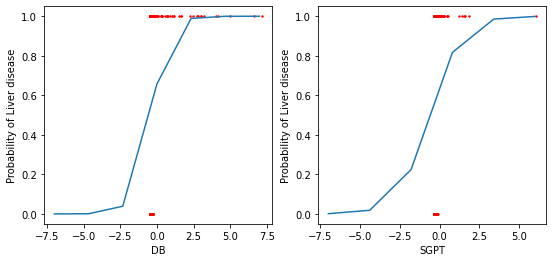

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (9,4))
ax1 = plot_logistic_curve(ax1, logistic_classifier, "DB", X_test, y_test)
ax2 = plot_logistic_curve(ax2, logistic_classifier, "SGPT", X_test, y_test)
plt.show()

The trend shows in both graphs that as DB and SGPT increase the probability of having a *Liver disease* increases.

###4.6 Decision tree
Decision trees is a discriminative supervised learning method, which involves the segmentation of the predictor space into a number of simple regions. The set of splitting rules used to segment the predictor space can be summarized in a tree, where the final regions $R_1, ..., R_J$ are known as terminal leaves, while the points where the predictor space is split are referred as internal nodes. Thanks to this easy interpretation, tree models are simple to understand and useful for visualization.

The induction of the tree follows a top-down approach since it begins from the top of the tree (where all the observations below to a single region) and then split the predictor space into two branches recursively, until a stopping criterion is reached (recursive binary splitting).
The procedure is greedy since at each step the best split is made by considering only that particular step rather than looking ahead.

Once the regions $R_1, ..., R_J$ have been created, we predict the class for a given test observation as the most commonly occurring class of training observations in the region to which it belongs.

Considering $\hat{p}_{mk}$ as the proportion of training observations in the mth region that are from the kth class, some of the most common functions to measure the quality of a split (purity) are:

- Gini: $G = \sum_{k=1}^K \hat{p}_{mk} (1 -\ \hat{p}_{mk})$, \
  which is a measure of the total variance across the $K$ classes. A small value of $G$ indicates that the node contains predominantly observations from a single class (the node is pure). 

- Cross entropy: $D = - \sum_{k=1}^K \hat{p}_{mk} \ log \ \hat{p}_{mk}$, \
 similarly to Gini, the Cross entropy index will take on a small value if the mth node is pure.

Decision-tree learners are prone to create over-complex trees that do not generalize the data well (overfitting). Mechanisms such as pruning, setting the minimum number of samples required to split an internal node or setting the maximum depth of the tree are necessary to avoid this problem.





**Experiments setting and results:**

Concerning the Decision Tree classifier, we try 2 different data settings:

- 1) Decision Tree (with all features)
- 2) KDecision Tree (with Reduced features)

PCA is not applied since we want to retain its interpretability, that is one of its main advantages.

Below the hyperparameters setting:

In [122]:
display(pd.DataFrame(config_dict['CLASSIFICATION']['PARAMS']['DecisionTree'], columns = ['DecisionTree__max_depth']).T)
display(pd.DataFrame(config_dict['CLASSIFICATION']['PARAMS']['DecisionTree'], columns = ['DecisionTree__min_samples_split']).T)
display(pd.DataFrame(config_dict['CLASSIFICATION']['PARAMS']['DecisionTree'], columns = ['DecisionTree__criterion']).T)

,0,1,2,3,4,5,6,7
DecisionTree__max_depth,2,3,4,5,6,7,8,9


,0,1,2,3,4,5,6,7
DecisionTree__min_samples_split,2,3,4,5,6,7,8,9


,0,1
DecisionTree__criterion,gini,entropy


#### 4.6.1 Decision Tree (with all features)
Nested-cross validation results:

Below the results obtained by averaging over the F1 scores of the outer loop in the nested cross-validation procedure. 
We can observe that the mean F1-score on the validation is considerably lower with respect to to the mean F1-score on the training set, suggesting that some degree of overfitting may have occurred.

Concerning the hyperparameters choice, we can notice that the max depth of the tree is fixed to the value of 9, while criterion and min samples split paramters oscillate among their possible range of values.

In [132]:
decision_tree_classifier = Classifier('DecisionTree', config_dict['CLASSIFICATION']['MODELS']['DecisionTree'], 
                            config_dict['CLASSIFICATION']['GENERAL'], 
                            config_dict['CLASSIFICATION']['PARAMS']['DecisionTree'], 
                            class_balancer, 
                            feature_scaler)
file_name = f'{decision_tree_classifier.name}.pkl'

if config_dict['GENERAL']['PERFORM_NCV']:
  decision_tree_mean_score, decision_tree_std_score = decision_tree_classifier.nested_cv(X_train, y_train, apply_PCA=False)
  save(decision_tree_classifier, os.path.join(MODELS_DIRPATH, file_name))
else:
  decision_tree_classifier = load(os.path.join(MODELS_DIRPATH, file_name))
  decision_tree_classifier.print_nested_cv_results()

decision_tree_classifier.cv(X_train, X_test, y_train, y_test, apply_PCA=False, print_res=False)
classifiers.append((decision_tree_classifier, "All features"))

Mean training F1-score = 0.92 (0.02)
Mean validation F1-score = 0.75 (0.04)

List of best hyperparameters to check stability: 


,0,1,2,3,4,5,6,7,8,9
DecisionTree__criterion,gini,entropy,gini,gini,entropy,entropy,gini,gini,entropy,gini
DecisionTree__max_depth,9,9,9,9,9,9,9,9,9,9
DecisionTree__min_samples_split,4,5,6,5,5,2,2,6,4,3


#### 4.6.2 Decision Tree (Reduced features)

Nested-cross validation results:

The results obtained by removing the duplicated features are lower with respect to the ones obtained considering all the features. This time, we can observe that a max depth equal to 8 is chosen for some inner loops.

In [133]:
feature_scaler_red = ColumnTransformer(remainder='passthrough',
                                       transformers=[("standardscaler", StandardScaler(), num_cols_without_duplicate)],
                                       verbose_feature_names_out=False)

feature_scaler1 = clone(feature_scaler_red)
_ = feature_scaler1.fit_transform(X_train_reduced) # to retreive the categorical features indices (order of columns is modified by the scaler)

#set categorical features indices
class_balancer_red = config_dict['CLASSIFICATION']['BALANCER']['SMOTENC'].set_params(categorical_features=[i for i, f in enumerate(feature_scaler1.get_feature_names_out()) if f in config_dict['GENERAL']['BOOLEAN_FEATURES']])

decision_tree_classifier_red = Classifier('DecisionTree', config_dict['CLASSIFICATION']['MODELS']['DecisionTree'], 
                               config_dict['CLASSIFICATION']['GENERAL'], 
                               config_dict['CLASSIFICATION']['PARAMS']['DecisionTree'], 
                               class_balancer_red, 
                               feature_scaler_red)
file_name = f'{decision_tree_classifier_red.name}_red.pkl'

if config_dict['GENERAL']['PERFORM_NCV']:
  decision_tree_mean_score_red, decision_tree_std_score_red = decision_tree_classifier_red.nested_cv(X_train_reduced, y_train, apply_PCA=False)
  save(decision_tree_classifier_red, os.path.join(MODELS_DIRPATH, file_name))
else:
  decision_tree_classifier_red = load(os.path.join(MODELS_DIRPATH, file_name))
  decision_tree_classifier_red.print_nested_cv_results()

decision_tree_classifier_red.cv(X_train_reduced, X_test_reduced, y_train, y_test, apply_PCA=False, print_res=False)
classifiers.append((decision_tree_classifier_red, "Reduced features"))

Mean training F1-score = 0.89 (0.03)
Mean validation F1-score = 0.71 (0.05)

List of best hyperparameters to check stability: 


,0,1,2,3,4,5,6,7,8,9
DecisionTree__criterion,entropy,gini,entropy,gini,gini,gini,gini,gini,entropy,gini
DecisionTree__max_depth,9,8,9,9,8,9,8,9,9,8
DecisionTree__min_samples_split,4,6,7,5,7,3,2,4,4,7


**Decision tree results:**

Now we train the Decision tree with all the features, which is the best model found (mean F1-score on validation = 0.75), on the entire training set. By performing grid search, with stratified 5-fold cross validation (see section 4.2), we obtain criterion = 5, max depth = 9 and min samples split = 6 as best parameters.
Then we test the trained model on the test data set. Below the results obtained:

>> Predicting on test dataset...
Best hyperparameters:


,DecisionTree__criterion,DecisionTree__max_depth,DecisionTree__min_samples_split
0,gini,9,6



Test classification report
              precision    recall  f1-score   support

           0       0.46      0.56      0.51        34
           1       0.80      0.73      0.77        83

    accuracy                           0.68       117
   macro avg       0.63      0.65      0.64       117
weighted avg       0.70      0.68      0.69       117



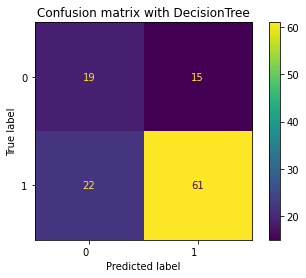

In [134]:
decision_tree_classifier.cv(X_train, X_test, y_train, y_test, apply_PCA=False)

From the classification report we can see that the recall is higher with respect to the value found with the Logistic Regression (0.66) and with the KNN (0.64), but is lower with respect to the one found with the SVM - Rbf kernel (0.86), indeed the model is not able to find a good part of the positive cases in the data (22 samples out to 83).

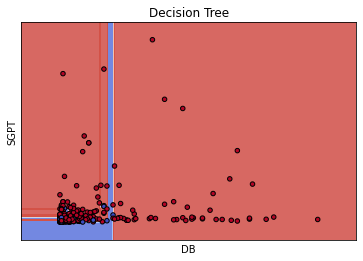

In [127]:
params = decision_tree_classifier.best_model.named_steps[decision_tree_classifier.name].get_params()

plot_2D_svm_decision_boundary_wrap(X_train, y_train, X_test, y_test, tree.DecisionTreeClassifier(**params), 
                              features_pair=['DB','SGPT'], title="Decision Tree", apply_PCA=False)

By inspecting the generated tree, we can try to interpret in an easy way the classifier and extrapolate concerns about the most important features. The decision tree is plotted, for visualization purposes, by considering a max depth equal to 3.

From the tree graph we can notice that many of the features chosen as most informative predictors in those first splits are consistent with the observation made in section 2.3. 
With a depth equal to 3, we obtain just one leaf node that is highly pure, since is entropy is zero, but with a small cardinality (#samples = 5).

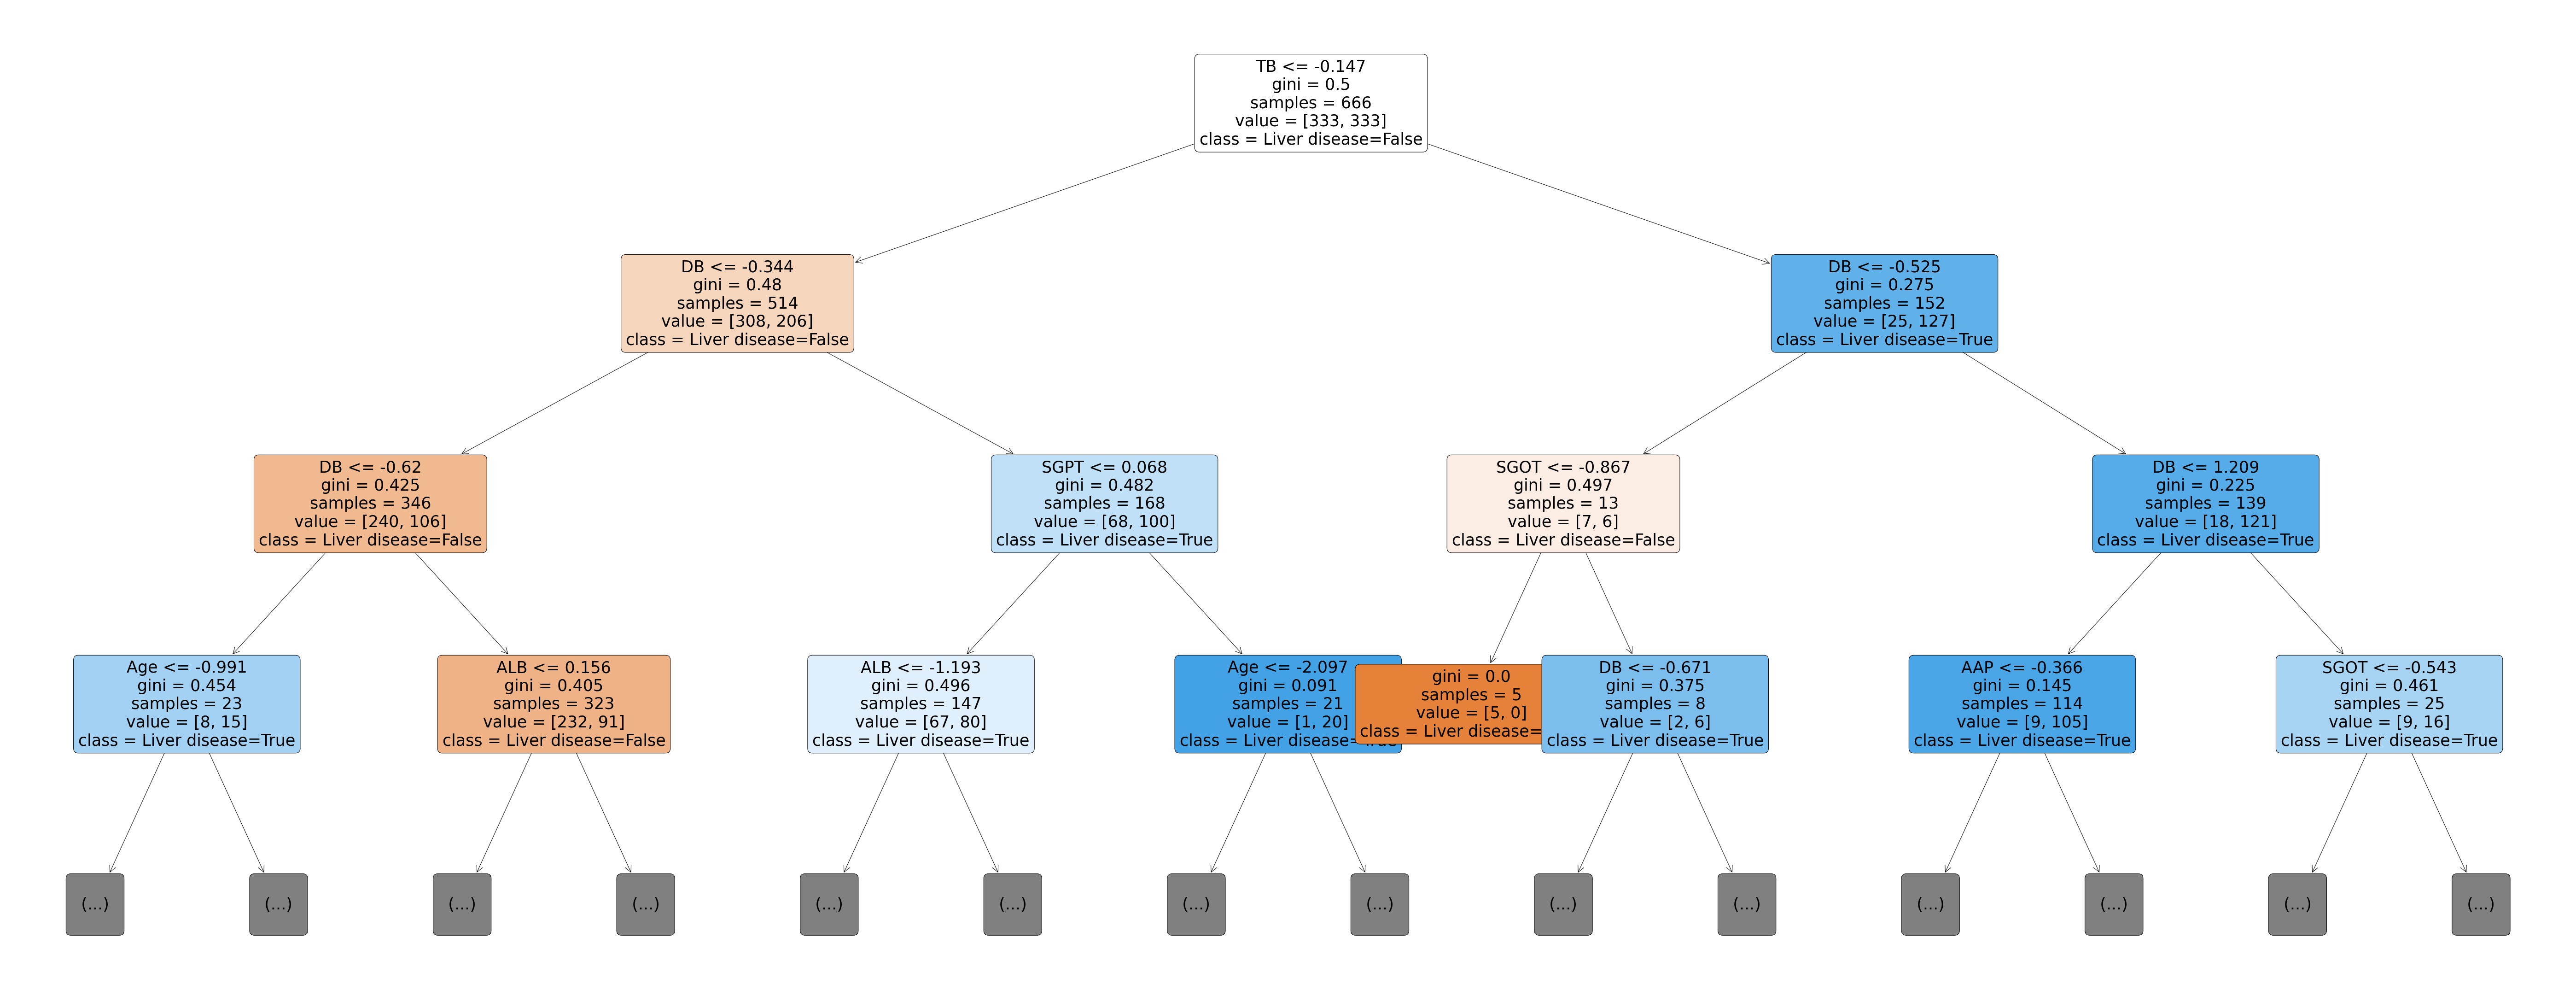

In [128]:
plot_decision_tree(decision_tree_classifier, features_names, config_dict['GENERAL']['TARGET_COLUMN_NAME'], max_depth=3) # max_depth=None to show full tree

###4.7 Random forest
Random forest is an ensemble method that consists in producing multiple trees which are then combined to obtain a single consensus prediction.
Random forest leverages the idea of bootstrap aggregation (or bagging), which is a general-purpose procedure to reduce the variance of learning methods. The idea of bagging is to generate B different bootsrapped training datasets, train the method on them and finally average the predictions, to obtain:

$\hat{f}_{bag}(x) = \frac{1}{B} \sum_{b=1}^B \hat{f}^{*b}(x)$

In Random Forest the base learner is the Decision Tree, which is a model that alone typically exhibit high variance and tend to overfit. Like bagging, Random Forest consists in building a number of models (decision trees in this case) on bootstrapped training samples. The main difference with respect to bagging is that each time a split in the tree is considered, a random sample of m predictors is chosen as split candidates and not the full set.


In [ ]:
display(pd.DataFrame(config_dict['CLASSIFICATION']['PARAMS']['RandomForest'], columns = ['RandomForest__criterion']).T)
display(pd.DataFrame(config_dict['CLASSIFICATION']['PARAMS']['RandomForest'], columns = ['RandomForest__max_depth']).T)
display(pd.DataFrame(config_dict['CLASSIFICATION']['PARAMS']['RandomForest'], columns = ['RandomForest__min_samples_split']).T)
display(pd.DataFrame(config_dict['CLASSIFICATION']['PARAMS']['RandomForest'], columns = ['RandomForest__max_features']).T)

,0,1
RandomForest__criterion,gini,entropy


,0,1,2,3,4,5,6,7
RandomForest__max_depth,2,3,4,5,6,7,8,9


,0,1,2
RandomForest__min_samples_split,2,5,10


,0
RandomForest__max_features,sqrt


In [ ]:
random_forest_classifier = Classifier('RandomForest', config_dict['CLASSIFICATION']['MODELS']['RandomForest'], 
                            config_dict['CLASSIFICATION']['GENERAL'], 
                            config_dict['CLASSIFICATION']['PARAMS']['RandomForest'], 
                            class_balancer, 
                            feature_scaler)
file_name = f'{random_forest_classifier.name}.pkl'

if config_dict['GENERAL']['PERFORM_NCV']:
  random_forest_score, random_forset_std_score = random_forest_classifier.nested_cv(X_train, y_train, apply_PCA=False, num_components=num_components)
  save(random_forest_classifier, os.path.join(MODELS_DIRPATH, file_name))
else:
  random_forest_classifier = load(os.path.join(MODELS_DIRPATH, file_name))
  random_forest_classifier.print_nested_cv_results()

random_forest_classifier.cv(X_train, X_test, y_train, y_test, apply_PCA=False, print_res=False)
classifiers.append((random_forest_classifier, "All features"))

Mean training F1-score = 0.94 (0.02)
Mean validation F1-score = 0.74 (0.04)

List of best hyperparameters to check stability: 


,0,1,2,3,4,5,6,7,8,9
RandomForest__criterion,entropy,gini,gini,entropy,gini,gini,gini,entropy,gini,entropy
RandomForest__max_depth,9,9,9,9,9,9,9,8,9,9
RandomForest__max_features,sqrt,sqrt,sqrt,sqrt,sqrt,sqrt,sqrt,sqrt,sqrt,sqrt
RandomForest__min_samples_split,5,2,10,5,2,10,5,2,2,10
RandomForest__n_estimators,10,10,10,100,10,100,100,10,10,10


**Random forest results:**

>> Predicting on test dataset...
Best hyperparameters:


,RandomForest__criterion,RandomForest__max_depth,RandomForest__max_features,RandomForest__min_samples_split,RandomForest__n_estimators
0,entropy,9,sqrt,5,10



Test classification report
              precision    recall  f1-score   support

           0       0.47      0.44      0.45        34
           1       0.78      0.80      0.79        83

    accuracy                           0.69       117
   macro avg       0.62      0.62      0.62       117
weighted avg       0.69      0.69      0.69       117



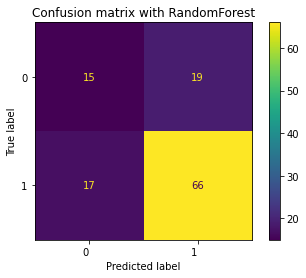

In [ ]:
random_forest_classifier.cv(X_train, X_test, y_train, y_test, apply_PCA=False)

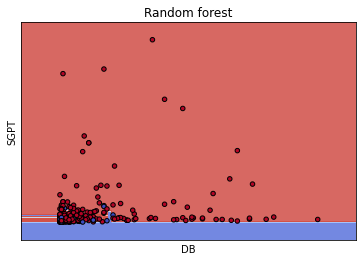

In [ ]:
params = random_forest_classifier.best_model.named_steps[random_forest_classifier.name].get_params()

plot_2D_svm_decision_boundary_wrap(X_train, y_train, X_test, y_test, ensemble.RandomForestClassifier(**params), 
                              features_pair=['DB','SGPT'], title="Random forest", apply_PCA=False)

###Configure the final model

In [ ]:
best_classifiers = []
best_score = 0
y_preds = []
clf_names = []
for classifier_tuple in classifiers:  
  classifier = classifier_tuple[0]   
  if classifier.ncv_global_mean_score > best_score:
      best_score = classifier.ncv_global_mean_score

for classifier_tuple in classifiers: 
  classifier = classifier_tuple[0]  
  if classifier.ncv_global_mean_score == best_score:
    best_classifiers.append((classifier, classifier_tuple[1]))
  y_preds.append(classifier.y_pred)
  name = f'{classifier.name} - {classifier_tuple[1]}'
  clf_names.append(name)

for best_classifier_tuple in best_classifiers:
  best_classifier = best_classifier_tuple[0]    
  print(f'\nBEST CLASSIFIER: {best_classifier.name} (F1-score={round(best_classifier.ncv_global_mean_score, 2)}), {best_classifier_tuple[1]}')



BEST CLASSIFIER: RbfSVC (F1-score=0.76), PCA


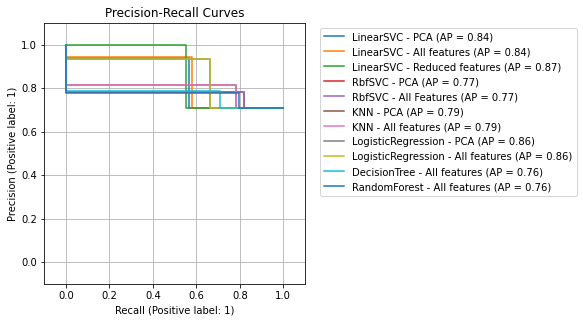

In [ ]:
plot_PRC(clf_names, y_preds, y_test)

##Conclusions